In [8]:
import pandas as pd
import xarray as xr
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import dask
from dask import delayed, compute
from itertools import product
from importlib import reload
from functools import partial

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# My imports
import os, sys
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import my_stats
import toe_calc
import toe_calc_variations
import toe_constants as toe_const
import toe_plots
from toe_plots import METRIC_MAP
import utils

In [11]:
logger = utils.get_notebook_logger()

In [12]:
xr.set_options(display_expand_data=False)

In [13]:
SAVE_DIR = '/g/data/w40/ab2313/time_of_emergence/synthetic_data'

In [14]:
from dask.distributed import Client, wait
# client.close()  # Close existing client
client = Client(n_workers=104, threads_per_worker=1, memory_limit=None)
client

 - State start
 -   Scheduler at:     tcp://127.0.0.1:41623
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:35419'
 -         Start Nanny at: 'tcp://127.0.0.1:38151'
 -         Start Nanny at: 'tcp://127.0.0.1:37201'
 -         Start Nanny at: 'tcp://127.0.0.1:44351'
 -         Start Nanny at: 'tcp://127.0.0.1:35267'
 -         Start Nanny at: 'tcp://127.0.0.1:38791'
 -         Start Nanny at: 'tcp://127.0.0.1:43571'
 -         Start Nanny at: 'tcp://127.0.0.1:40331'
 -         Start Nanny at: 'tcp://127.0.0.1:36099'
 -         Start Nanny at: 'tcp://127.0.0.1:33875'
 -         Start Nanny at: 'tcp://127.0.0.1:36601'
 -         Start Nanny at: 'tcp://127.0.0.1:43519'
 -         Start Nanny at: 'tcp://127.0.0.1:43825'
 -         Start Nanny at: 'tcp://127.0.0.1:44915'
 -         Start Nanny at: 'tcp://127.0.0.1:40067'
 -         Start Nanny at: 'tcp://127.0.0.1:33663'
 -         Start Nanny at: 'tcp://127.0.0

<Client: 'tcp://127.0.0.1:41623' processes=104 threads=104>

 - Event loop was unresponsive in Nanny for 3.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Nanny for 3.10s.  This is often caused by long

<h1 style='color:cyan'> Universal Functions  </h1>

In [15]:
import scipy
from itertools import product

In [16]:
# np.random.gamma
# np.random.weibull
# scipy.stats.genextreme.rvs#(c, loc, scale, size)
# # np.random.lognormal(mean, sigma, size)

In [17]:
def rescale_noise(arr, target_std): return arr / np.std(arr) * target_std

In [18]:
import numpy as np
from scipy.signal import lfilter

def generate_red_noise(size=100, std=0.2, alpha=0):
    """
    Generates red noise (AR(1) process) with a specified standard deviation.

    Parameters:
    size (int): Length of the generated red noise sequence (default: 100).
    std (float): Desired standard deviation of the output red noise (default: 0.2).
    alpha (float): Autoregressive parameter (default: 0, which gives white noise).

    Returns:
    np.ndarray: Red noise sequence with the specified standard deviation.
    """

    # Generate standard normal white noise
    noise = np.random.normal(0, std, size)
    
    # Apply AR(1) filter to introduce autocorrelation
    if alpha: noise = lfilter([1], [1, -alpha], noise)
        
    # Normalize the output to match the desired standard deviation
    noise = rescale_noise(noise, std)
    # noise = noise / np.std(noise) * std
    return noise

In [19]:
def non_stationary_noise(arr: np.ndarray, start_std: float, end_std: float, window: int) -> np.ndarray:
    """
    Apply a linearly varying noise multiplier to an array.

    The function scales the input array using a smoothly increasing 
    standard deviation multiplier. The standard deviation starts at 
    a lower value and linearly increases, reaching `start_std` at 
    index `window//2` and `end_std` at `len(arr) - window//2`.

    Parameters:
    -----------
    arr : np.ndarray
        Input array to be scaled.
    start_std : float
        Standard deviation multiplier at index `window//2`.
    end_std : float
        Standard deviation multiplier at index `len(arr) - window//2`.
    window : int
        Defines the range within which the standard deviation scaling begins and ends.

    Returns:
    --------
    np.ndarray
        Scaled array with non-stationary noise applied.
    """

    n = len(arr)
    start_idx = window // 2
    end_idx = n - window // 2

    std_mult_series = np.linspace(
        start_std - (start_idx / (end_idx - start_idx)) * (end_std - start_std),
        end_std + ((n - end_idx) / (end_idx - start_idx)) * (end_std - start_std),
        n
    )

    return arr * std_mult_series

In [20]:
sample_ts = generate_red_noise(300, 1, 0)

In [21]:
sample_ts_new = non_stationary_noise(sample_ts, start_std=0.1, end_std=1, window=30)

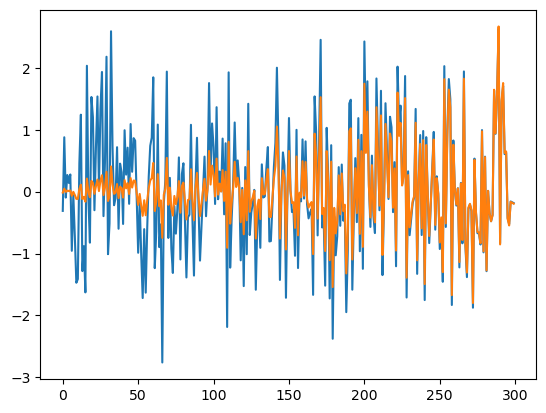

In [22]:
plt.plot(sample_ts)
plt.plot(sample_ts_new)

In [23]:
std_list = np.arange(0.1, 0.5, 0.1)
rho_list = np.arange(0.1, 0.5, 0.1)

for std, rho in product(std_list, rho_list):
    output_std = np.std(generate_red_noise(300, std, rho))
    print(f'{std=:.2f} - {rho=:.2f} - {output_std:.2f} - ({(std-output_std):.2f})')


std=0.10 - rho=0.10 - 0.10 - (-0.00)
std=0.10 - rho=0.20 - 0.10 - (0.00)
std=0.10 - rho=0.30 - 0.10 - (-0.00)
std=0.10 - rho=0.40 - 0.10 - (0.00)
std=0.20 - rho=0.10 - 0.20 - (-0.00)
std=0.20 - rho=0.20 - 0.20 - (-0.00)
std=0.20 - rho=0.30 - 0.20 - (0.00)
std=0.20 - rho=0.40 - 0.20 - (-0.00)
std=0.30 - rho=0.10 - 0.30 - (0.00)
std=0.30 - rho=0.20 - 0.30 - (0.00)
std=0.30 - rho=0.30 - 0.30 - (0.00)
std=0.30 - rho=0.40 - 0.30 - (-0.00)
std=0.40 - rho=0.10 - 0.40 - (-0.00)
std=0.40 - rho=0.20 - 0.40 - (0.00)
std=0.40 - rho=0.30 - 0.40 - (0.00)
std=0.40 - rho=0.40 - 0.40 - (-0.00)


In [24]:
def generate_base_noise(distribution, **kwargs):
    """
    Returns a pre-configured noise generation function with fixed parameters.

    Parameters:
    distribution (str): The distribution to slog in as the base noise source.
    **kwargs: Additional parameters required for each distribution.

    Returns:
    function: A function that generates noise samples when called.
    """

    if distribution == "normal": return partial(np.random.normal, **kwargs)
    elif distribution == "gamma": return partial(np.random.gamma, **kwargs)
    elif distribution == "lognormal": return partial(np.random.lognormal, **kwargs)
    elif distribution == "weibull": return partial(np.random.weibull, **kwargs)
    elif distribution == "exponential": return partial(np.random.exponential, **kwargs)
    elif distribution == "gumbel": return partial(np.random.gumbel, **kwargs)
    elif distribution == "poisson": return partial(np.random.poisson, **kwargs)
    else:
        raise ValueError(
            "Unsupported distribution type. Choose from: normal, gamma, lognormal, weibull, exponential, gumbel, poisson."
        )

In [25]:
def generate_noise_process(size, alpha, noise_func):
    """
    Generates an autocorrelated noise process (AR(1) process) using a given noise function.

    Parameters:
    size (int): Length of the generated noise sequence.
    alpha (float): Autoregressive parameter (0 gives uncorrelated noise).
    noise_func (function): Pre-configured function to generate noise samples.

    Returns:
    np.ndarray: Noise process sequence with the specified autocorrelation.
    """
    
    # Generate noise using the pre-configured function
    base_noise = noise_func(size)

    # Apply AR(1) filter to introduce autocorrelation
    noise_process = lfilter([1], [1, -alpha], base_noise)

    # Normalize the output to match the original standard deviation
    noise_process = noise_process / np.std(noise_process) * np.std(base_noise)

    return noise_process

In [26]:
# # Create a noise generator with specific parameters
# gamma_noise = generate_base_noise("gamma", shape=2, scale=0.5)
# lognormal_noise = generate_base_noise("lognormal", mean=0, sigma=0.3)

# # Use it in the AR(1) noise process
# gamma_series = generate_noise_process(size=1000, alpha=0.8, noise_func=gamma_noise)
# lognormal_series = generate_noise_process(size=1000, alpha=0.5, noise_func=lognormal_noise)


In [27]:
def generate_noise_ensemble(std: float, rho: float, num_trials: int = 200, 
                            atol: float = None, rtol: float = None, length: int = 100, 
                            batch_size: int = 100):
    """
    Generate an ensemble of red noise series with a specified standard deviation in parallel batches.

    Parameters:
    - std: Target standard deviation of the noise series.
    - rho: Autoregressive coefficient for red noise.
    - num_trials: Number of noise series to generate.
    - atol: Absolute tolerance for matching the desired standard deviation.
    - rtol: Relative tolerance for matching the desired standard deviation.
    - length: Length of each noise series.
    - batch_size: Number of noise series processed in a single batch.

    Returns:
    - A NumPy array containing the noise ensemble.
    """

    if atol is None and rtol is None:
        atol = 0.05 * std
    elif rtol is not None:
        atol = rtol * std

    print(f'\n{std=} - {rho=} - {length=} - {atol=}\n')

    @delayed
    def generate_batch():
        """ Generate a batch of red noise and filter valid samples. """
        samples = np.array([generate_red_noise(length, std, rho) for _ in range(batch_size)])
        stds = np.std(samples, axis=1)
        valid_samples = samples[(stds > (std - atol)) & (stds < (std + atol))]
        print(f'len - {len(valid_samples)}')
        return valid_samples

    collected_samples = []
    to_compute = []

    
    batch_num = 0  # Track batch number
    while len(collected_samples) < num_trials:
        batch_num += 1
        print(f"{batch_num} ({len(collected_samples)}), ", end='')  # Print batch number
    
        batch = generate_batch()  # Create delayed task
        valid_samples = compute(batch)[0]  # Compute after each batch
        
        collected_samples.extend(valid_samples)

        # # Stop if we have enough samples
        # if len(collected_samples) >= num_trials:
        #     break

    # Trim to exactly `num_trials`
    noise_series_arr = np.array(collected_samples[:num_trials])

    # Convert to xarray
    noise_bs_xr = xr.DataArray(
        noise_series_arr,
        dims=("iteration", "time"),
        coords={"iteration": np.arange(num_trials), "time": np.arange(length),
               'rho': rho, 'std': std}
    ).chunk({'iteration':'auto', 'time':-1})


    return noise_bs_xr

<h1 style='color:cyan'> Universal Parameters </h1>

* Defining true trend

In [28]:
base_period_length = 30
window = 30

In [29]:
base_period = np.tile(0, base_period_length)
grad = 1.2/140 # 1.2 degree change since 1850
# grad = 0.6/140 # 1.2 degree change since 1850

trend_line = grad * np.arange(470)  # Linear trend

true_trend = np.concatenate([base_period, trend_line])
true_trend.shape

(500,)

In [30]:
x = np.linspace(0, true_trend.shape[0], 6000)

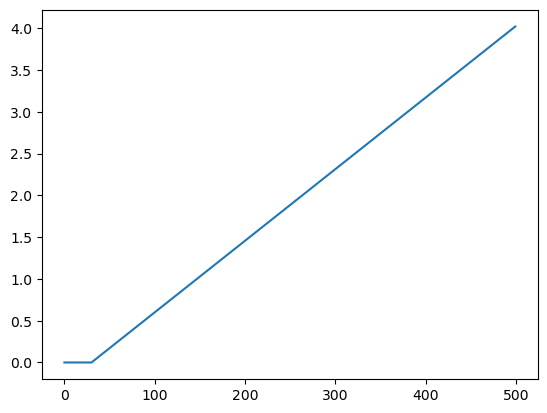

In [31]:
plt.plot(true_trend)

In [32]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)
kde_create_kwargs = dict(
    input_core_dims=[['iteration']],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=[float]
)

<h1 style='color:cyan'> Single Ensemble </h1>

In [33]:
np.random.seed(51)

# # Generate time series
# n = 150  # Number of time points
# base_period = np.tile(0, 30)
# grad = 1.2/130 # 1.2 degree change since 1850
# trend_line = grad * np.arange(150)  # Linear trend

# true_trend = np.concatenate([base_period, trend_line])
t = np.arange(len(true_trend))

In [34]:
base_noise = generate_red_noise(len(true_trend), std=0.25, alpha=0.3)
base_noise.shape

(500,)

In [35]:
target_std = [0.25, 0.5, 1, 2]

In [36]:
noise_series = np.asarray([rescale_noise(base_noise, std) for std in target_std])

In [37]:
np.std(noise_series, axis=1)

array([0.25, 0.5 , 1.  , 2.  ])

In [38]:
noise_series.shape

(4, 500)

In [39]:
# # Define the iterations coordinate
# # num_iterations = 4
# iterations = np.arange(1, num_iterations + 1)
# iterations

In [40]:
# Compute noisy signals (vectorized)
noisy_signals = true_trend/4 + np.outer(iterations, base_noise)

# Convert to xarray DataArray
noisy_series_xr = xr.DataArray(
    noisy_signals,
    dims=( "noise_index","time"),  # Using 'noise_index' as requested
    coords={"noise_index": np.arange(num_iterations),  "time": t}
)

NameError: name 'iterations' is not defined

In [ ]:
noisy_signals.shape

In [ ]:
noisy_series_xr

In [ ]:
nrows = 2
ncols = 2
num_plot = nrows*ncols


fig = plt.figure(figsize=(6*nrows, 3.5*ncols))
gs = gridspec.GridSpec(nrows, ncols, hspace=0.3)
axes = [fig.add_subplot(gs[i]) for i in range(num_plot)]

time = noisy_series_xr.time.values

for i in np.arange(num_iterations):

    noisy_series = noisy_series_xr.sel(noise_index=i).values

    
    axes[i].plot(time, noisy_series, color='red', alpha=0.6)
    # axes[i].plot(t, true_trend, linestyle='dashed', color='black', label='True Trend')
    
    axes[i].set_title(f'Standard Deviation={np.std(noise_series[i]):.2f}')
    # axes[i].legend()
    axes[i].grid(True)

    axes[i].set_xlim(0, len(time))
    axes[i].set_ylim(-2.4, 5)
    
# axes[0].set_ylabel('Value')
for ax in axes:
    ax.set_xlabel('Time (years)')

# plt.tight_layout()

In [ ]:
signal_df = xr.apply_ufunc(
    my_stats.apply_lowess,
    noisy_series_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [ ]:
signal_df.plot(hue='noise_index');

In [ ]:
noise_df = noisy_series_xr.isel(time=slice(0,30)).std(dim='time')
noise_df

In [ ]:
sn_df = signal_df/noise_df

In [ ]:
sn_df.plot(hue='noise_index');

<h1 style='color:cyan'> Rho and Std </h1>

<h2 style='color:yellow'> Generating Data </h2>

In [34]:
std_values = [0.1, 0.25, 0.5, 0.75, 1]
rho_values = [0, 0.25, 0.5, 0.75]

# First, concatenate along std
std_concat_list = []
for std in std_values:
    rho_concat_list = [
        generate_noise_ensemble(
            std, rho, length=true_trend.shape[0],
            rtol=0.2, num_trials=10000)
        for rho in rho_values]
    std_concat_list.append(xr.concat(rho_concat_list, dim="rho"))

# Then, concatenate along rho
noise_ensemble_da = xr.concat(std_concat_list, dim="std")


std=0.1 - rho=0 - length=500 - atol=0.020000000000000004

1 (0), 2 (100), 3 (200), 4 (300), 5 (400), 6 (500), 7 (600), 8 (700), 9 (800), 10 (900), 11 (1000), 12 (1100), 13 (1200), 14 (1300), 15 (1400), 16 (1500), 17 (1600), 18 (1700), 19 (1800), 20 (1900), 21 (2000), 22 (2100), 23 (2200), 24 (2300), 25 (2400), 26 (2500), 27 (2600), 28 (2700), 29 (2800), 30 (2900), 31 (3000), 32 (3100), 33 (3200), 34 (3300), 35 (3400), 36 (3500), 37 (3600), 38 (3700), 39 (3800), 40 (3900), 41 (4000), 42 (4100), 43 (4200), 44 (4300), 45 (4400), 46 (4500), 47 (4600), 48 (4700), 49 (4800), 50 (4900), 51 (5000), 52 (5100), 53 (5200), 54 (5300), 55 (5400), 56 (5500), 57 (5600), 58 (5700), 59 (5800), 60 (5900), 61 (6000), 62 (6100), 63 (6200), 64 (6300), 65 (6400), 66 (6500), 67 (6600), 68 (6700), 69 (6800), 70 (6900), 71 (7000), 72 (7100), 73 (7200), 74 (7300), 75 (7400), 76 (7500), 77 (7600), 78 (7700), 79 (7800), 80 (7900), 81 (8000), 82 (8100), 83 (8200), 84 (8300), 85 (8400), 86 (8500), 87 (8600), 88 (8

In [35]:
true_trend.shape

(500,)

In [36]:
noise_ensemble_da

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

In [37]:
trend_bs_xr = noise_ensemble_da + true_trend

In [38]:
trend_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


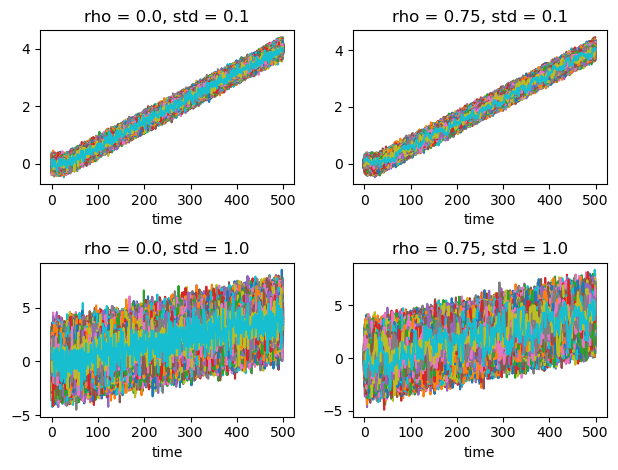

In [39]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

trend_bs_xr.sel(std=0.1, rho=0).plot(ax=axes[0], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=0.1, rho=0.75).plot(ax=axes[1], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=1, rho=0).plot(ax=axes[2], hue='iteration', add_legend=False);
trend_bs_xr.sel(std=1, rho=0.75).plot(ax=axes[3], hue='iteration', add_legend=False);

plt.tight_layout()

<h2 style='color:yellow'> ToE Calclulation </h2>

In [40]:
data_ds_window = (trend_bs_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (trend_bs_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window);
wait(base_period_window_ds);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 763.01 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [41]:
trend_bs_xr

<xarray.DataArray (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0

### KS and Overlap

In [42]:
# # The arguements needed for all of the calculations
# rolling_window_kwargs = dict(
#     input_core_dims=[['window_dim'], ['window_dim']],
#     exclude_dims={'window_dim'},
#     vectorize=True,
#     dask='parallelized')

In [43]:
# %%time
# # Expected 3 minutes 30 seconds - best
# # 6 23 - era5
# ks_ds = xr.apply_ufunc(
#         toe_calc.return_ks_pvalue,
#         data_ds_window,
#         base_period_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [44]:
%%time
ks_ds = toe_calc_variations.ks(data_ds_window, base_period_window_ds)

In [45]:
# import toe_calc_variations

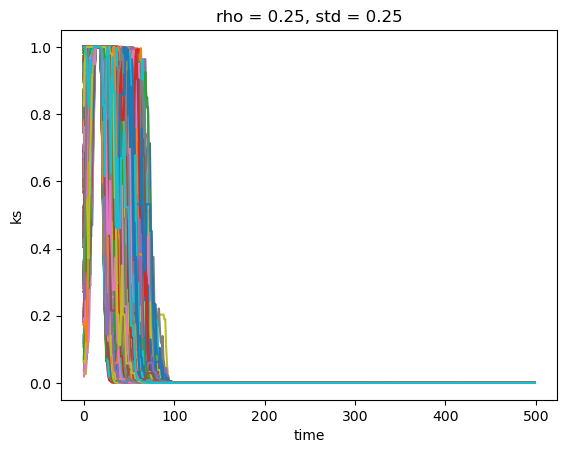

In [46]:
ks_ds.sel(rho=0.25, std=0.25).plot(hue='iteration', add_legend=False);

In [47]:
%%time
fga_ds = toe_calc_variations.fga(
    trend_bs_xr, trend_bs_xr.isel(time=slice(0, base_period_length)), data_ds_window).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.95 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [48]:
fga_ds

<xarray.DataArray 'frac' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
81.89 83.64 90.0 88.37 88.43 ... 0.0109 0.00677 1.947e-12 2.821e-25 2.827e-26
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
Attributes:
    bw_method:   0.2
    bmin:        -4.91480215867236
    bmax:        8.865021559479432
    num_points:  1000

### S/N Ratio

In [49]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, base_period_length)).mean(dim='time')

In [50]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 762.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [51]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, base_period_length)).std(dim='time')

In [52]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 801.09 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


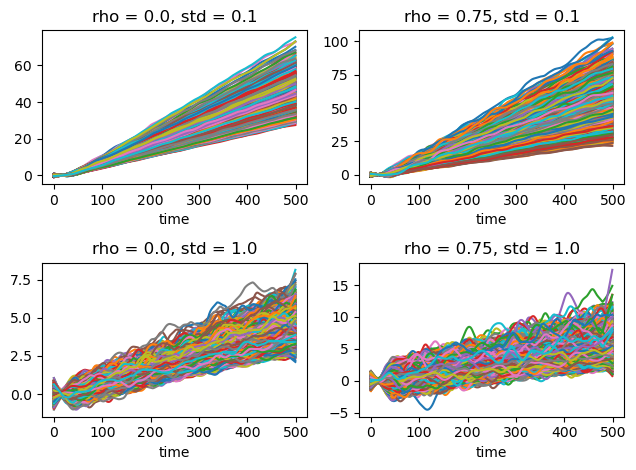

In [53]:
fig, axes = plt.subplots(2, 2)
axes = axes.ravel()

sn_bs_xr.sel(std=0.1, rho=0).plot(ax=axes[0], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=0.1, rho=0.75).plot(ax=axes[1], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=1, rho=0).plot(ax=axes[2], hue='iteration', add_legend=False);
sn_bs_xr.sel(std=1, rho=0.75).plot(ax=axes[3], hue='iteration', add_legend=False);

plt.tight_layout()

<h2 style='color:yellow'> Saving and Opening Data </h2>

In [47]:
# sn_bs_xr.to_zarr(os.path.join(SAVE_DIR, 'sn_rho_std.zarr'), mode='w')
# ks_ds.to_zarr(os.path.join(SAVE_DIR, 'ks_rho_std.zarr'), mode='w')
# fga_ds.to_zarr(os.path.join(SAVE_DIR, 'fga_rho_std.zarr'), mode='w')

In [48]:
# trend_bs_xr.to_zarr(os.path.join(SAVE_DIR, 'trend_rho_std.zarr'), mode='w')
trend_bs_xr = xr.open_dataset(os.path.join(SAVE_DIR, 'trend_rho_std.zarr'), engine='zarr')

In [49]:
trend_bs_xr = trend_bs_xr.to_array().squeeze().drop_vars('variable')
trend_bs_xr.name = 'data'

In [50]:
trend_bs_xr

<xarray.DataArray 'data' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
0.02337 -0.04017 -0.05108 -0.1258 0.03391 ... 3.575 4.685 5.403 4.767 4.115
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [51]:
chunks = {'time':-1, 'iteration':200}

In [52]:
sn_bs_xr = (xr.open_zarr(os.path.join(SAVE_DIR, 'sn_rho_std.zarr'))
            .chunk(**chunks)
            .to_array()
            .squeeze().drop_vars('variable')
            )
sn_bs_xr.name = 'sn'
ks_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'ks_rho_std.zarr')).ks.chunk(**chunks)
fga_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'fga_rho_std.zarr')).frac.chunk(**chunks)

In [53]:
ks_ds

<xarray.DataArray 'ks' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [54]:
sn_bs_xr

<xarray.DataArray 'sn' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
dask.array<chunksize=(1, 1, 200, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [55]:
trend_bs_xr

<xarray.DataArray 'data' (std: 5, rho: 4, iteration: 10000, time: 500)> Size: 800MB
0.02337 -0.04017 -0.05108 -0.1258 0.03391 ... 3.575 4.685 5.403 4.767 4.115
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * rho        (rho) float64 32B 0.0 0.25 0.5 0.75
  * std        (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

<h2 style='color:yellow'> ToE </h2>

In [56]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater,
    time=sn_bs_xr.time.values)

In [57]:
ks_toe_bs_xr = toe_calc.get_permanent_exceedance(
            ks_ds, threshold=0.01, comparison_func=np.less, time=sn_bs_xr.time.values)

In [58]:
fga_toe_bs_xr = toe_calc.get_permanent_exceedance(
            fga_ds, threshold=62, comparison_func=np.less, time=sn_bs_xr.time.values)

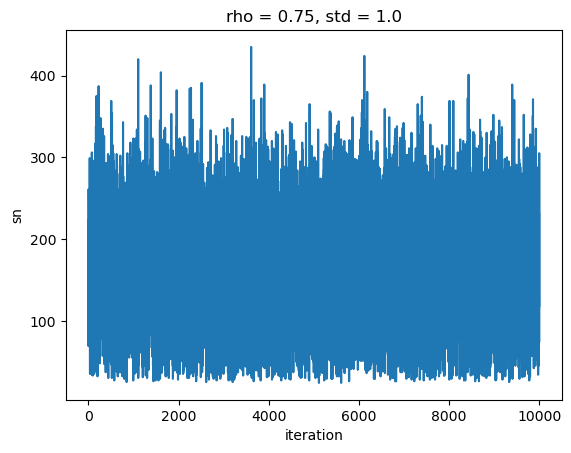

In [59]:
sn_toe_bs_xr.sel(std=1, rho=0.75).plot()

In [60]:
%%time
sn_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    sn_toe_bs_xr,
    dask_gufunc_kwargs={'allow_rechunk':True},
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 5.33 s, sys: 1.82 s, total: 7.16 s
Wall time: 9.27 s


In [61]:
%%time
ks_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    ks_toe_bs_xr,
    dask_gufunc_kwargs={'allow_rechunk':True},
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 4.7 s, sys: 926 ms, total: 5.63 s
Wall time: 6.03 s


In [62]:
%%time
fga_toe_bs_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    fga_toe_bs_xr,
    dask_gufunc_kwargs={'allow_rechunk':True},
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 4.45 s, sys: 850 ms, total: 5.3 s
Wall time: 5.53 s


In [63]:
ks_toe_bs_kde_xr['x'] = x
sn_toe_bs_kde_xr['x'] = x
fga_toe_bs_kde_xr['x'] = x

In [64]:
sn_toe_bs_xr = sn_toe_bs_xr.compute()
ks_toe_bs_xr = ks_toe_bs_xr.compute()
fga_toe_bs_xr = fga_toe_bs_xr.compute()

<h2 style='color:yellow'> Plotting </h2>

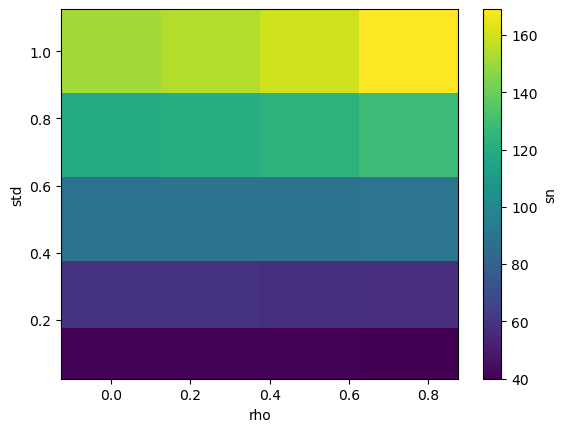

In [65]:
sn_toe_bs_xr.median(dim='iteration').plot()

In [66]:
fga_toe_bs_xr.std(dim='iteration').to_pandas().round(0)

rho   0.00  0.25  0.50  0.75
std                         
0.10   4.0   4.0   5.0   7.0
0.25   9.0  10.0  13.0  17.0
0.50  17.0  21.0  25.0  34.0
0.75  25.0  30.0  38.0  51.0
1.00  33.0  39.0  49.0  67.0

In [67]:
print(sn_toe_bs_xr.std(dim='iteration').to_pandas().round(0))

rho   0.00  0.25  0.50  0.75
std                         
0.10   4.0   4.0   6.0   8.0
0.25   8.0  10.0  13.0  18.0
0.50  17.0  20.0  25.0  35.0
0.75  25.0  30.0  38.0  52.0
1.00  32.0  39.0  49.0  68.0


In [68]:
print(sn_toe_bs_xr.mean(dim='iteration').to_pandas().round(0))

rho    0.00   0.25   0.50   0.75
std                             
0.10   41.0   41.0   41.0   40.0
0.25   59.0   59.0   58.0   58.0
0.50   88.0   89.0   89.0   91.0
0.75  120.0  121.0  124.0  129.0
1.00  151.0  155.0  159.0  170.0


In [69]:
fga_toe_bs_xr.mean(dim='iteration').to_pandas().round(0)

rho    0.00   0.25   0.50   0.75
std                             
0.10   42.0   42.0   41.0   40.0
0.25   57.0   57.0   57.0   55.0
0.50   86.0   86.0   86.0   86.0
0.75  116.0  117.0  119.0  121.0
1.00  147.0  151.0  154.0  159.0

In [70]:
def plot_toe_bs_kde(toe_bs_kde_xr, toe_bs_xr, colors=None, fig=None, axs=None,
                    add_legend=True, ylabel=True):
    """
    Plots Time of Emergence (ToE) bootstrapped KDE distributions for different std values, with vertical median lines.
    
    Parameters:
    - toe_bs_kde_xr: xarray.Dataset containing KDE distributions for ToE
    - toe_bs_xr: xarray.Dataset containing raw ToE values for computing medians
    - x: numpy array of x-axis values
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    # Get unique values for rho and std
    rho_values = toe_bs_kde_xr['rho'].values
    std_values = toe_bs_kde_xr['std'].values
    x = toe_bs_kde_xr.x.values
    
    # Assign a unique color to each rho for consistency across plots
    if colors is None: colors = plt.cm.viridis(np.linspace(0, 1, len(rho_values)))
    
    # Create figure and gridspec if not provided
    if fig is None or axs is None:
        fig = plt.figure(figsize=(6, len(std_values) * 1.5))
        gs = gridspec.GridSpec(len(std_values), 1, figure=fig, hspace=0)
        axs = [fig.add_subplot(gs[i, 0]) for i in range(len(std_values))]
    
    # Loop through std (rows)
    for i, (ax, std) in enumerate(zip(axs, std_values)):
        # Plot all rho values on the same subplot, using consistent colors
        for color, rho in zip(colors, rho_values):
            data = toe_bs_kde_xr.sel(std=std, rho=rho)
            ax.plot(x, data, color=color, label=f'{rho:.2f}')
            
            # Compute and plot the median vertical line
            median_x = np.nanmedian(toe_bs_xr.sel(std=std, rho=rho).values)
            median_y = data.values[np.argmin(np.abs(x - median_x))]
            ax.plot([median_x, median_x], [0, median_y], linestyle="dashed",
                    color=color, alpha=0.7)

        
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, min_n_ticks=4, prune=None))
        ax.set_xlim(0, 350)
        if i == 0 and add_legend: 
            leg = ax.legend(loc='upper right', ncol=2, fontsize=12, frameon=False)
            leg.set_title('Lag-1 Auto-correlation')
            leg.get_title().set_fontsize(12)
        if 0 < i < len(std_values) - 1:
            # ax.spines['bottom'].set_visible(False)
            ax.set_xticklabels([])
        if i == len(std_values) - 1:
            ax.set_xlabel('Time of Emergence (ToE)') 
        if i == 0:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('top')
        if ylabel: ax.set_ylabel(fr'$\sigma={std}$', fontsize=12)  
        ax.grid(True, linestyle='--', alpha=0.25, color='grey')
    
    return fig, axs


In [71]:
colors = plt.cm.viridis_r(np.linspace(0, 1, sn_toe_bs_kde_xr['rho'].values.shape[0]))

In [72]:
std_values = sn_toe_bs_kde_xr['std'].values

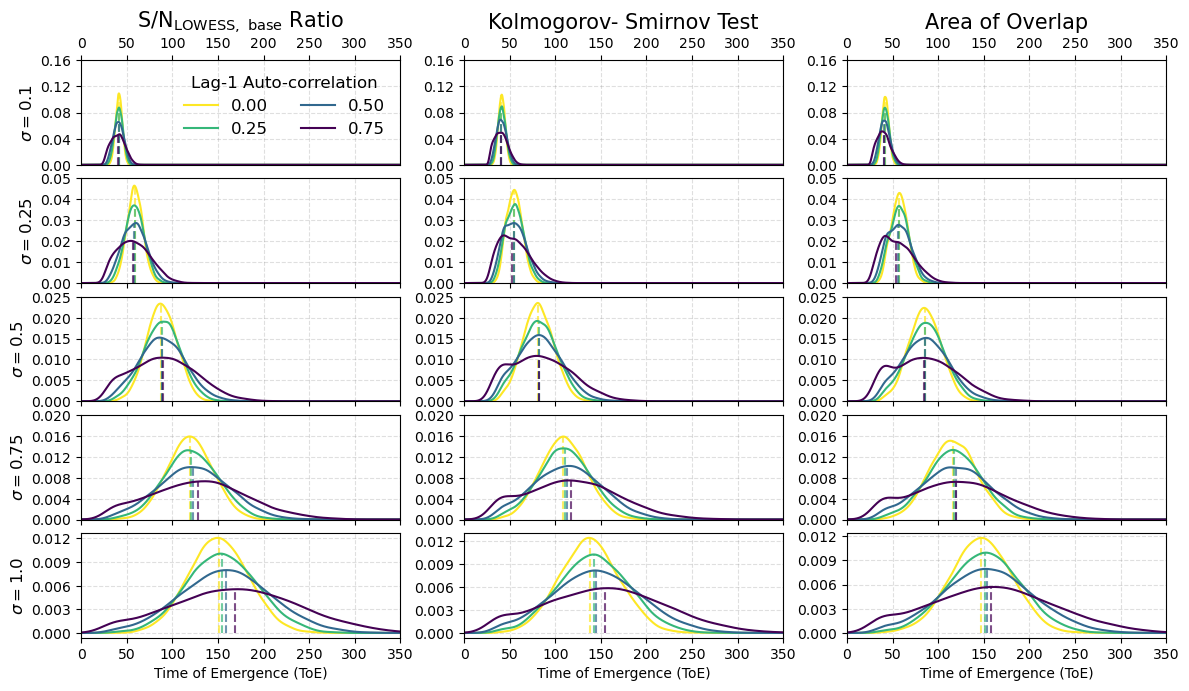

In [73]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(14, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 3, figure=fig, hspace=0.13)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_middle = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 2]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_middle, colors=colors, ylabel=False, add_legend=False);
plot_toe_bs_kde(fga_toe_bs_kde_xr, fga_toe_bs_xr, fig=fig, axs=axes_right, colors=colors, ylabel=False, add_legend=False);


axes_left[0].set_title(METRIC_MAP['sn'], fontsize=15)
axes_middle[0].set_title(METRIC_MAP['ks'].replace('\n', ' '), fontsize=15)
axes_right[0].set_title(METRIC_MAP['frac'].replace('\n', ' '), fontsize=15)


for axes in [axes_left, axes_middle, axes_right]:
    for i,ax in enumerate(axes):
        if i == 0: ax.set_ylim(0, 0.16)
        if i == 1:ax.set_ylim(0, 0.05)
        if i == 2: ax.set_ylim(0, 0.025)
        if i==3: ax.set_ylim(0, 0.02)

In [74]:
sn_toe_bs_kde_xr

<xarray.DataArray 'sn' (std: 5, rho: 4, x: 6000)> Size: 960kB
0.0 0.0 0.0 9.881e-324 5.336e-322 ... 3.887e-11 3.775e-11 3.667e-11 3.562e-11
Coordinates:
  * rho      (rho) float64 32B 0.0 0.25 0.5 0.75
  * std      (std) float64 40B 0.1 0.25 0.5 0.75 1.0
  * x        (x) float64 48kB 0.0 0.08335 0.1667 0.25 ... 499.8 499.9 500.0

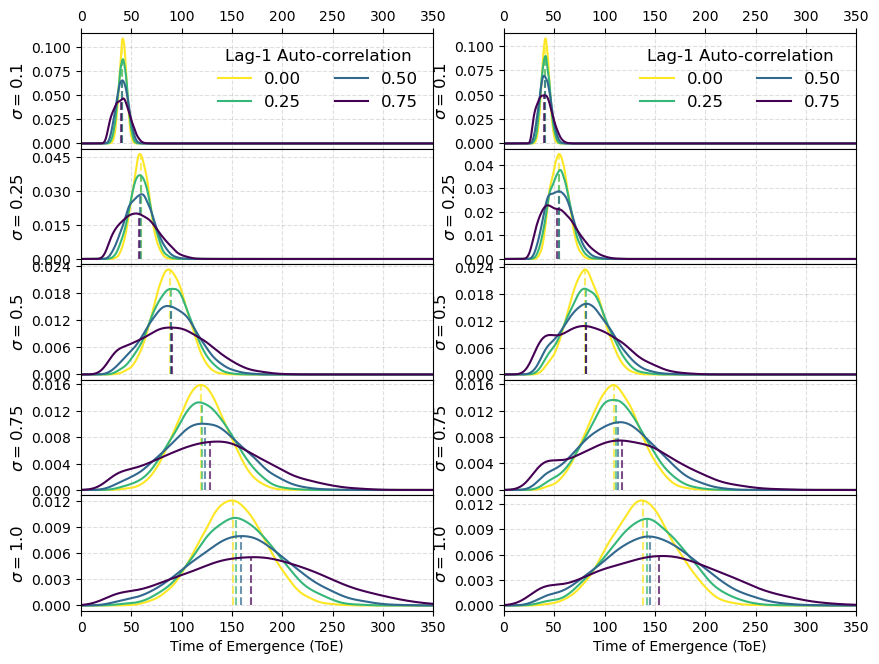

In [75]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(10, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 2, figure=fig, hspace=0)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_right, colors=colors);

<h1 style='color:cyan'> Non-stationary Variance </h1>

This is different as the noise now changes from one to the other by the point that emergence occurs

<h2 style='color:yellow'> Genearting Data </h2> 

In [76]:
from itertools import combinations

In [77]:
non_stat_noise_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    vectorize=True,
    dask = 'parallelized',
    output_dtypes=[float]
)

In [78]:
def apply_variance_time_change(
    arr, window_size=10, start_std=1.0, end_std=2.0, base_period_length=False,
    logginglevel='ERROR'
):
    """
    Scale the standard deviation of each window in the array, increasing
    linearly from start_std to end_std. Optionally leave a base period unchanged.

    Parameters:
    - arr: 1D array-like
    - window_size: number of elements per window (after the base period)
    - start_std: target std for the first modified window
    - end_std: target std for the last modified window
    - base_period: if True, the first 30 elements are untouched

    Returns:
    - A new array with increasing standard deviation in windows
    """
    utils.change_logginglevel(logginglevel)

    arr = np.asarray(arr)
    result = np.empty_like(arr)


    if base_period_length:
        args = np.concatenate([
            [0, base_period_length],
            np.arange(base_period_length+window_size, len(arr)+window_size, window_size)
        ])
    else:
        args = np.arange(0, len(arr), window_size)

    logger.info(args)

    segments = [arr[args[i]:args[i+1]] for i in range(len(args)-1)]

    # The segment si too small, merge with the previous segment
    if len(segments[-1]) < window_size:
        segments[-2] = [*segments[-2], *segments[-1]]
        segments = segments[:-1]
    
    target_stds = np.linspace(start_std, end_std, len(segments))

    scaled_segments= np.concatenate(
        [rescale_noise(segments[i], target_stds[i]) for i in range(len(segments))]
    )

    return scaled_segments

In [79]:
def apply_variance_time_change_xr(
    da, start_std, end_std,
    change_var_length=None, base_period_length=30, window_size=30, total_length=None,
    logginglevel='ERROR'
):
    """
    Applies non-stationary noise to a DataArray, transitioning between two standard deviation values over time.
    
    Parameters
    ----------
    da : xr.DataArray
        The input data array to which noise will be added.
    start_std : float
        The initial standard deviation of the noise.
    end_std : float
        The final standard deviation of the noise.
    length : int, optional
        The number of time steps over which the standard deviation transitions from start_std to end_std.
        After this, the noise is rescaled to maintain end_std.
    window : int, default=30
        The moving window size used to compute local standard deviation during noise scaling.
    
    Returns
    -------
    xr.DataArray
        A DataArray with noise applied, transitioning from start_std to end_std over the specified length.
    """

    utils.change_logginglevel(logginglevel)
    logger.debug(locals())
    logger.debug('\n')
    
    da_new = xr.apply_ufunc(
        apply_variance_time_change, 
        da.isel(time=slice(0, base_period_length+change_var_length)),
        kwargs = dict(
            start_std=start_std, end_std=end_std, window_size=window_size,
            base_period_length=base_period_length),
        **non_stat_noise_kwargs
    ).persist()
    
    wait(da_new);
    
    logger.debug(da_new)
    logger.debug('\n')

    if total_length:
        time_length = da_new.time.shape[0]
        logger.info(f'{time_length=}')
        logger.debug('\n')

        da_end = da.isel(time=slice(time_length, total_length))

        logger.debug(da_end)
        logger.info('\n')
        
        da_end_rescale = xr.apply_ufunc(
                rescale_noise, 
                da_end,
                kwargs = dict(target_std=end_std),
                **non_stat_noise_kwargs
            ).persist()

        logger.debug(da_end_rescale)
        logger.debug('\n')

        da_new = xr.concat([da_new, da_end_rescale], dim='time')

    return da_new

In [80]:
lengths = sn_toe_bs_xr.sel(rho=0).median(dim='iteration').astype(int)
lengths

<xarray.DataArray 'sn' (std: 5)> Size: 40B
41 59 88 119 151
Coordinates:
    rho      float64 8B 0.0
  * std      (std) float64 40B 0.1 0.25 0.5 0.75 1.0

In [81]:
# Remove the trend - for some reason trend was halved at some point????
trend_bs_da = trend_bs_xr.sel(rho=0, std=0.5)
nosie_bs_da =  trend_bs_da - true_trend

In [82]:
arr = nosie_bs_da.isel(iteration=2).values

In [83]:
# arr_std_start = 0.25
# arr_std_end = 0.75
arr_std_start = 0.25
arr_std_end = 0.75

In [84]:
arr_changed = apply_variance_time_change(
    arr, base_period_length=30, window_size=30, start_std=arr_std_start, end_std=arr_std_end)

In [85]:
np.std(arr_changed[:30]), np.std(arr_changed[-30:])

(0.25, 0.7093894231197372)

In [86]:
# da_std_start = 0.5#1#0.1
# da_std_end = 1
# change_var_length = 100

In [87]:
stds =  (0.1, 0.5, 1,)
std_change_list = list(combinations(stds, 2))
std_change_list

[(0.1, 0.5), (0.1, 1), (0.5, 1)]

In [88]:
std_change = std_change_list[0]
base_period_length = 30
window_size = 10#30
total_length = 150 # total_length = length * 2
length_increase = lengths.sel(std = std_change[0]).values.item() * 2
length_decrease = lengths.sel(std = std_change[-1]).values.item() * 2

In [89]:
std_change, length_increase, length_decrease

((0.1, 0.5), 82, 176)

In [90]:
iteration_num = 8

In [91]:
arr = nosie_bs_da.isel(iteration=iteration_num)

In [92]:
arr_changed = apply_variance_time_change(
    arr.isel(time=slice(0, 112)), base_period_length=base_period_length, window_size=window_size, 
    start_std = std_change[0], end_std=std_change[-1], logginglevel='DEBUG')

 - [  0  30  40  50  60  70  80  90 100 110 120]


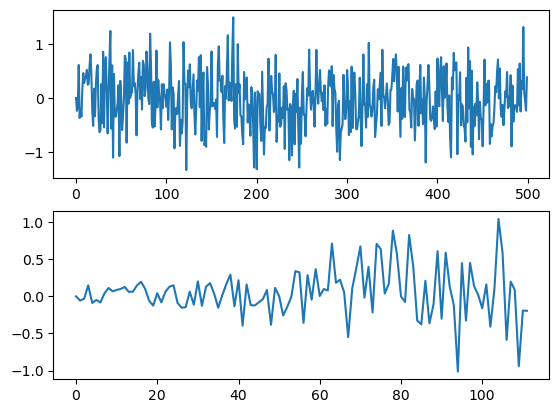

In [107]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(arr)
ax2.plot(arr_changed)

In [100]:
da_changed = apply_variance_time_change_xr(
    nosie_bs_da.isel(iteration=slice(0, 20)), start_std = std_change[0], end_std=std_change[-1],
    base_period_length=base_period_length, change_var_length=length_increase, 
    window_size=window_size, total_length=total_length,
    logginglevel='INFO'    
)

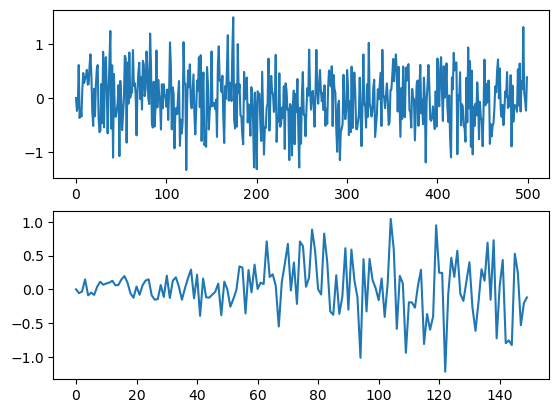

In [101]:
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(nosie_bs_da.isel(iteration=iteration_num).values)
ax2.plot(da_changed.isel(iteration=iteration_num).values)

In [108]:
np.testing.assert_allclose(
    da_changed.isel(time=slice(-70, None)).std(dim='time').values, std_change[-1],
    rtol=1)

In [109]:
np.testing.assert_allclose(
    da_changed.isel(time=slice(0, 30)).std(dim='time').values, std_change[0],
    rtol=1)

In [110]:
# If the var increases
    # Roll and base are the same: Thus variability is chaning too slowly
    # The shorten length
#If the emergence decreases - 
    # They are all the same
    # This means 

end_window_size = 100
base_period_length = 30
window_size = 10
total_length = 400 # total_length = length * 2
length_increase = lengths.sel(std = std_change[0]).values.item() * 2
length_decrease = lengths.sel(std = std_change[-1]).values.item() * 2

std_change_stor = []
length_dict = {}
for std_change in std_change_list:

    print(f'{std_change=}')

    # Increasing varaiblity length should be shorter, as this occurs earlier
    # 150 works the best

    # The justificion for this
    # The base period is the same - variability does not change in base period. Thus
    # the S/N base will be the same
    # The variance changes twice the length of the mean time for emergence to occur
    # Thus, the old ToE will be in the middle
    # However, this would be the case if there was not a base period. So subptract the lenght
    # of the base period to ensure that the ToE point is in the ceter of variance change

    # Increasing variance using the ToE of the start std
    # Decreasing varaicne uses the ToE of the end std
    length_increase = lengths.sel(std = std_change[0]).values.item() * 2 - base_period_length
    length_decrease = lengths.sel(std = std_change[-1]).values.item() * 2 - base_period_length

    length = np.max([length_increase, length_decrease])

    print(f'{length_increase=}, {length_decrease=}')
    
    base_noise_increase_xr = apply_variance_time_change_xr(
        nosie_bs_da, std_change[0], std_change[-1],
        window_size=window_size, change_var_length=length,
        base_period_length=base_period_length, total_length=total_length)
    
    base_noise_decrease_xr = apply_variance_time_change_xr(
        nosie_bs_da, std_change[-1], std_change[0],
        window_size = window_size, change_var_length=length,
        base_period_length=base_period_length, total_length=total_length)

    increase_name = str(std_change[0]).replace('.', 'p') + 't' + str(std_change[-1]).replace('.', 'p')
    decrease_name = str(std_change[-1]).replace('.', 'p') + 't' + str(std_change[0]).replace('.', 'p')
    
    base_noise_increase_xr['std'] = increase_name
    base_noise_decrease_xr['std'] = decrease_name

    
    length_dict[increase_name] = length
    length_dict[decrease_name] = length
    
    std_change_stor.append(base_noise_increase_xr)
    std_change_stor.append(base_noise_decrease_xr)

std_change=(0.1, 0.5)
length_increase=52, length_decrease=146
std_change=(0.1, 1)
length_increase=52, length_decrease=272
std_change=(0.5, 1)
length_increase=146, length_decrease=272


In [111]:
length_dict

{'0p1t0p5': 146,
 '0p5t0p1': 146,
 '0p1t1': 272,
 '1t0p1': 272,
 '0p5t1': 272,
 '1t0p5': 272}

In [112]:
base_noise_change_xr = xr.concat(std_change_stor, dim='std')
base_noise_change_xr

<xarray.DataArray 'data' (std: 6, iteration: 10000, time: 400)> Size: 192MB
0.05878 -0.003601 -0.02017 0.1044 -0.06908 ... 0.9808 0.03914 -0.1105 0.3443
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
    rho        float64 8B 0.0
  * std        (std) <U7 168B '0p1t0p5' '0p5t0p1' '0p1t1' ... '0p5t1' '1t0p5'
  * time       (time) int64 3kB 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399

In [113]:
base_noise_change_xr.isel(std=0).isel(iteration=0).isel(time=slice(0, 30)).std()

<xarray.DataArray 'data' ()> Size: 8B
0.1
Coordinates:
    iteration  int64 8B 0
    rho        float64 8B 0.0
    std        <U7 28B '0p1t0p5'

In [114]:
# Add the true trend back, but just to where you have changed the noise
new_time_length = base_noise_change_xr.time.shape[0]
trend_noise_change_xr  = base_noise_change_xr + true_trend[:new_time_length]
new_time_length

400

In [115]:
trend_noise_change_xr = trend_noise_change_xr.chunk({'std':1, 'time':-1, 'iteration':1000})
trend_noise_change_xr = trend_noise_change_xr.persist()
wait(trend_noise_change_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 183.11 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [116]:
iteration_num = 8

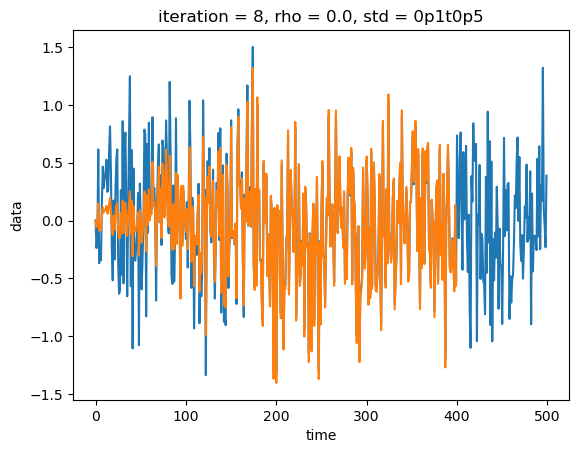

In [117]:
nosie_bs_da.isel(iteration=iteration_num).plot()
base_noise_change_xr.isel(iteration=iteration_num).isel(std=0).plot();

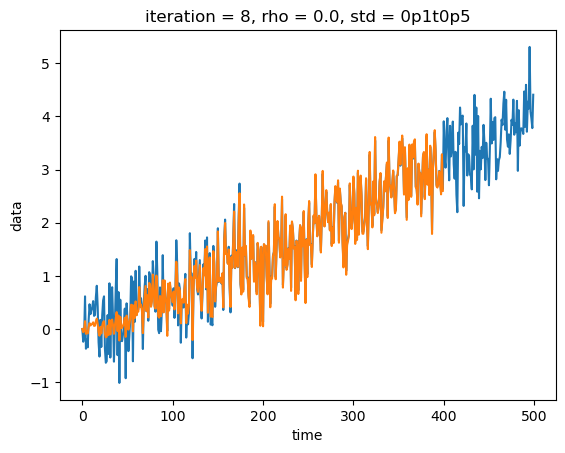

In [118]:
trend_bs_da.isel(iteration=iteration_num).plot()
trend_noise_change_xr.isel(iteration=iteration_num).isel(std=0).plot()

In [119]:
noise_values = base_noise_change_xr['std'].values
noise_values

array(['0p1t0p5', '0p5t0p1', '0p1t1', '1t0p1', '0p5t1', '1t0p5'],
      dtype='<U7')

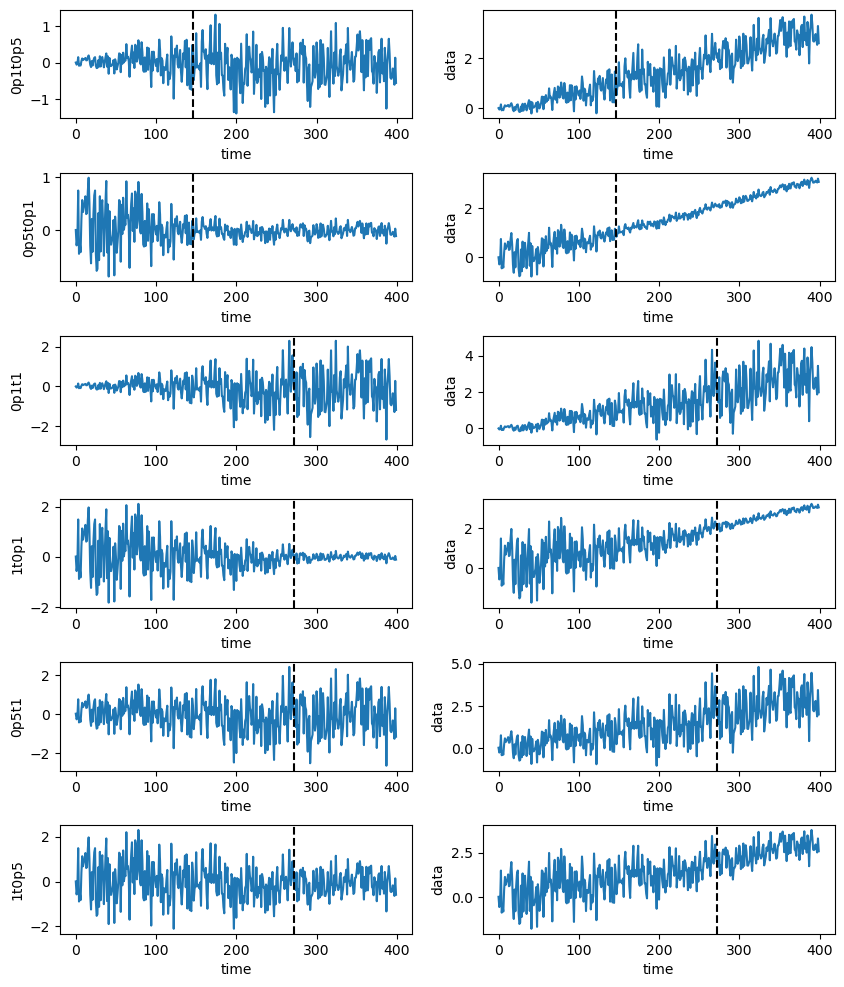

In [120]:

fig = plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(len(noise_values), 2, hspace=0.5)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(noise_values))]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(len(noise_values))]

for num, noise in enumerate(noise_values):

    ax = axes_left[num]
    base_noise_change_xr.isel(iteration=iteration_num).sel(std=noise).plot(ax=ax);
    ax.axvline(length_dict[noise], linestyle='--', color='k')
    ax.set_ylabel(noise)

    ax2 =  axes_right[num]
    trend_noise_change_xr.isel(iteration=iteration_num).sel(std=noise).plot(ax=ax2);
    ax2.axvline(length_dict[noise], linestyle='--', color='k')
    ax.set_title(None)
    ax2.set_title(None)

In [121]:
%%time
sn_non_stat_xr = toe_calc_variations.sn_ratio(
    trend_noise_change_xr,#.isel(iteration=slice(0,100)),
    start=0, end=30).persist()
wait(sn_non_stat_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 183.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 10.6 s, sys: 4.72 s, total: 15.3 s
Wall time: 21 s


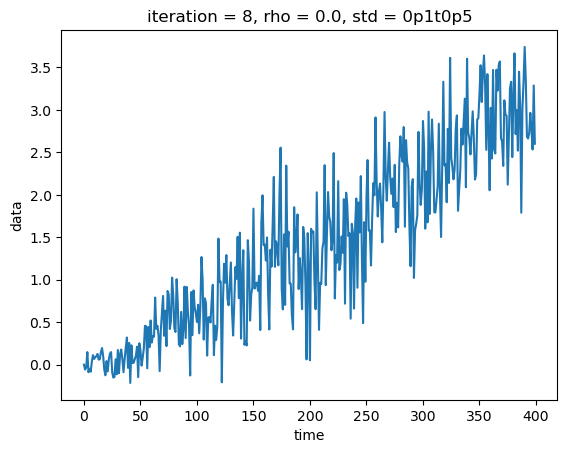

In [122]:
trend_noise_change_xr.isel(iteration=8, std=0).plot(hue='iteration', add_legend=False);

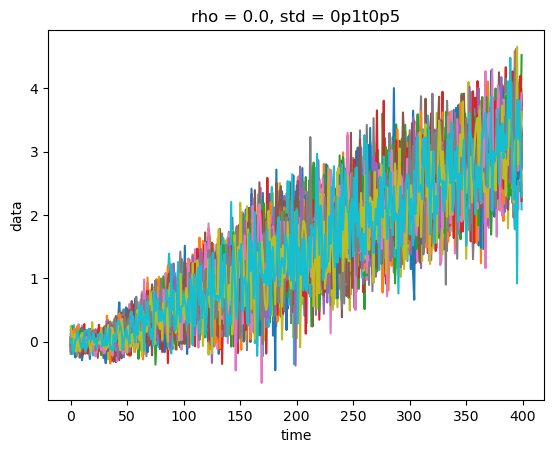

In [123]:
trend_noise_change_xr.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

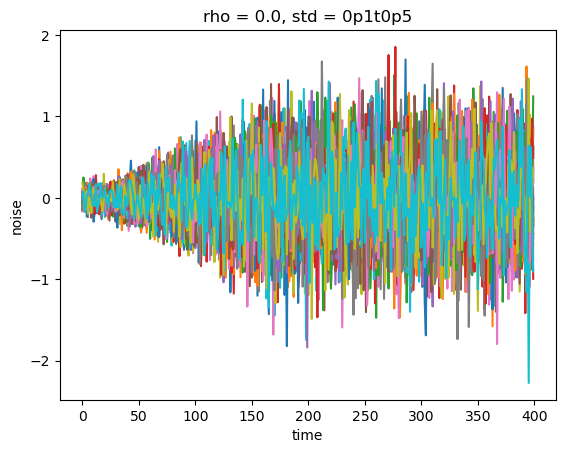

In [124]:
sn_non_stat_xr.isel(iteration=slice(0, 30), std=0).noise.plot(hue='iteration', add_legend=False);

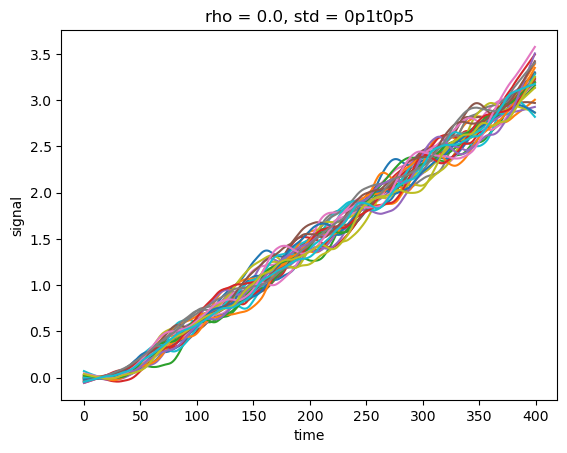

In [125]:
sn_non_stat_xr.signal.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

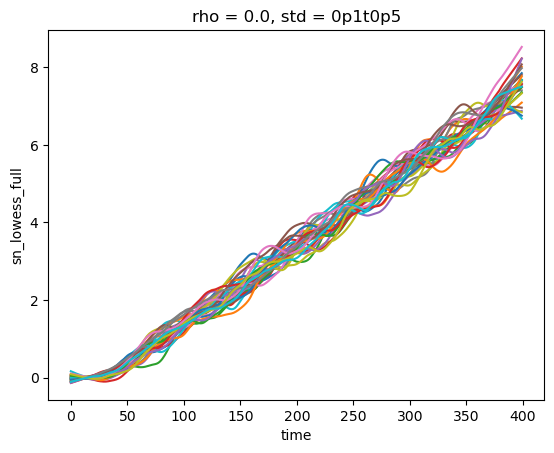

In [126]:
sn_non_stat_xr.sn_lowess_full.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

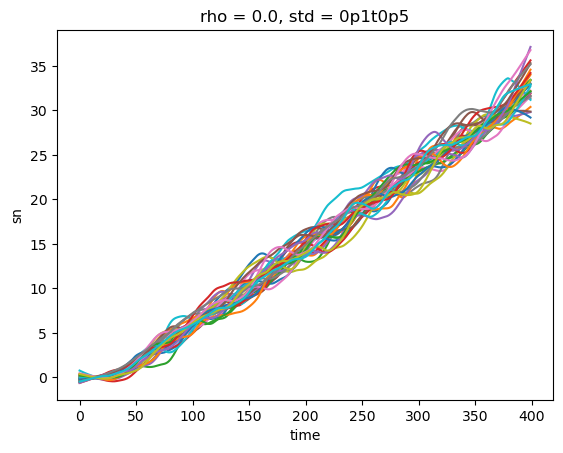

In [127]:
sn_non_stat_xr.sn.isel(iteration=slice(0, 30), std=0).plot(hue='iteration', add_legend=False);

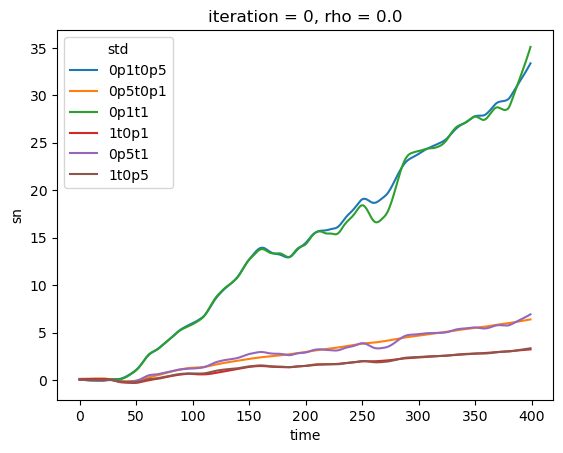

In [128]:
sn_non_stat_xr.sn.isel(iteration=0).plot(hue='std');

In [129]:
%%time
sn_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
    sn_non_stat_xr[['sn', 'sn_lowess_full', 'sn_roll']],
    threshold=1, comparison_func=np.greater,
    time=sn_non_stat_xr.time.values.astype(int), trim_nan=True).persist()
wait(sn_toe_non_stat_xr);

CPU times: user 4.68 s, sys: 163 ms, total: 4.85 s
Wall time: 4.78 s


In [130]:
sn_toe_non_stat_xr.sn_lowess_full.isel(iteration=slice(0, 100)).median(dim='iteration').compute()

<xarray.DataArray 'sn_lowess_full' (std: 6)> Size: 48B
80.0 59.5 117.0 108.0 137.5 126.0
Coordinates:
    rho      float64 8B 0.0
  * std      (std) <U7 168B '0p1t0p5' '0p5t0p1' '0p1t1' '1t0p1' '0p5t1' '1t0p5'

In [131]:
%%time
sn_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    sn_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 15.6 s, sys: 2.11 s, total: 17.7 s
Wall time: 10.9 s


In [132]:
np.max(x), np.mean(np.diff(x))

(500.0, 0.08334722453742291)

In [133]:
sn_toe_non_stat_kde_xr['x'] = x

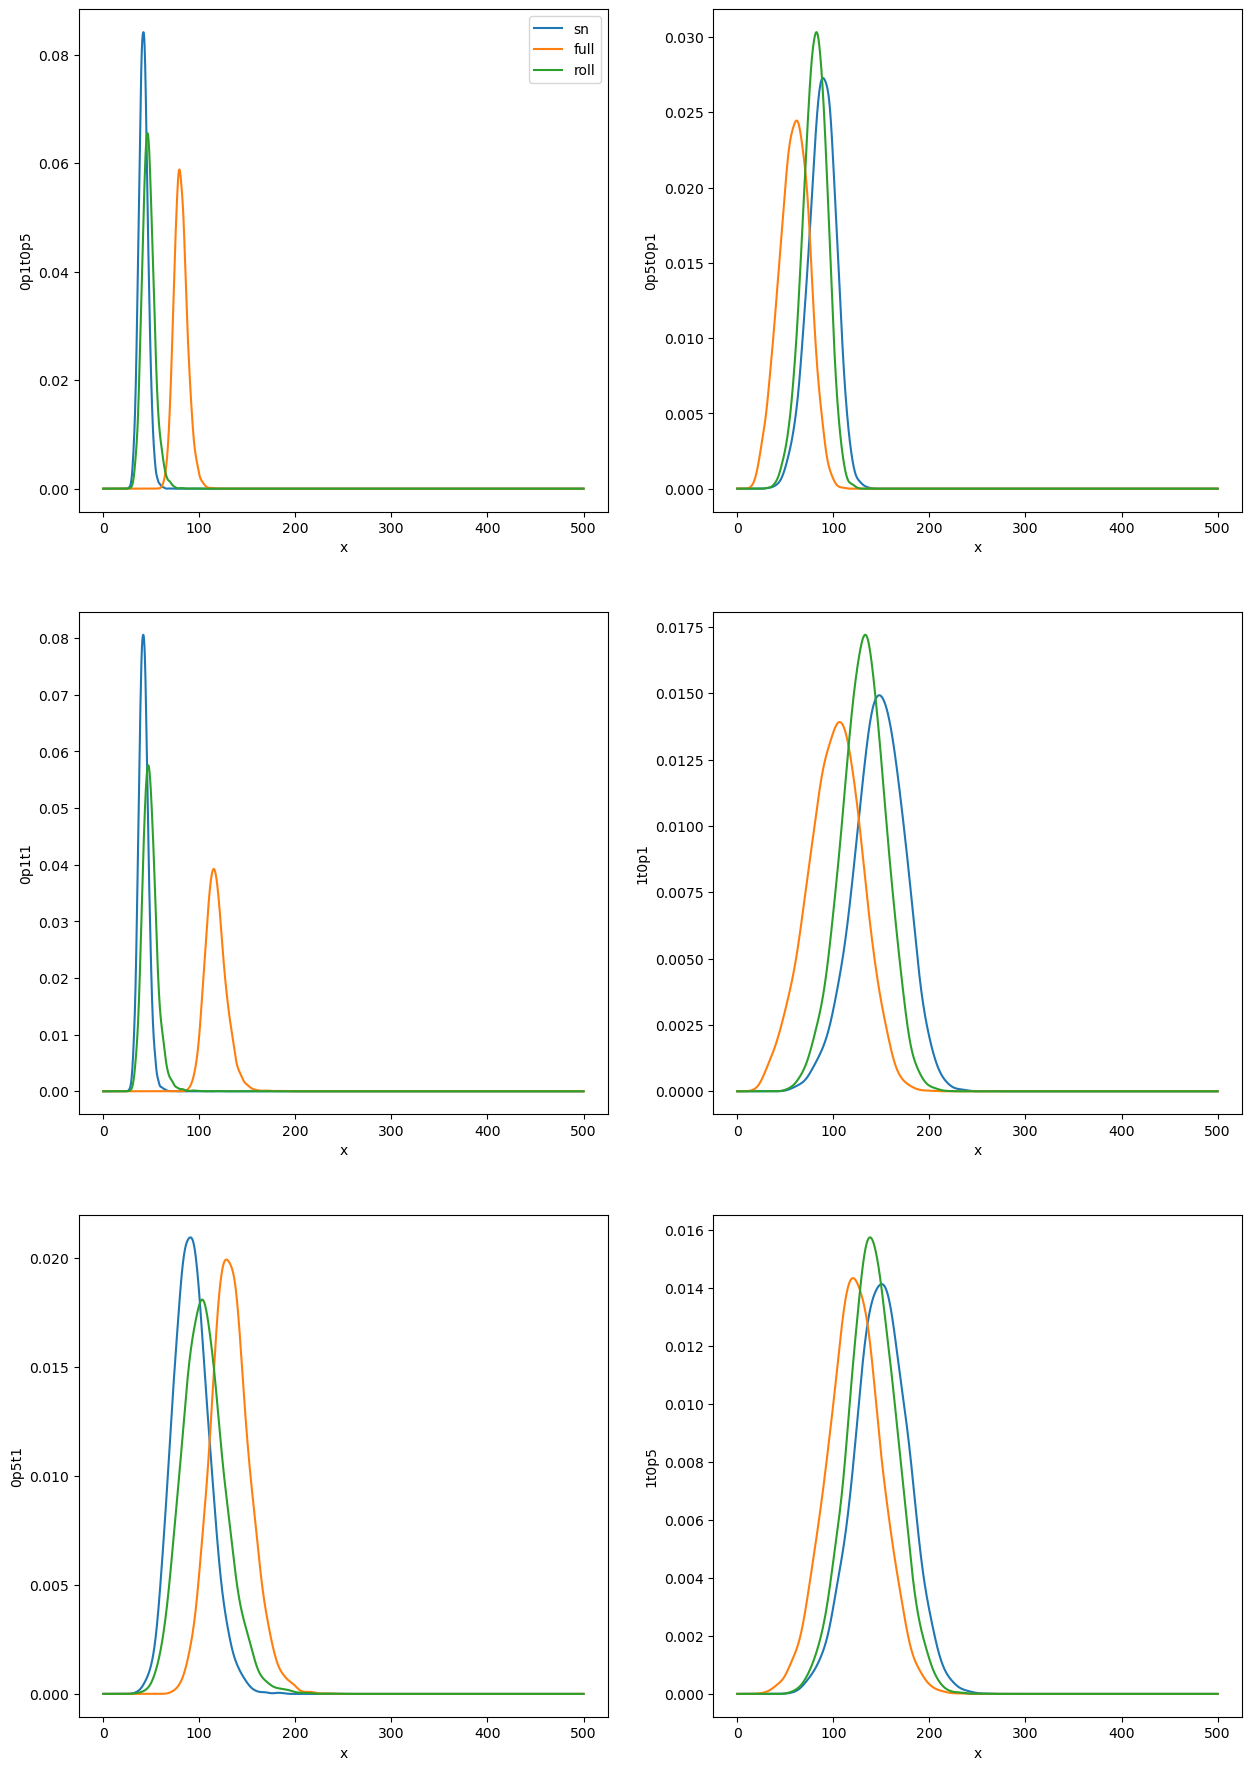

In [134]:
std_vals = sn_toe_non_stat_kde_xr['std'].values#[:10]

fig = plt.figure(figsize=(15, 30))

axes = [fig.add_subplot(len(std_vals)//2+1, 2, i+1) for i in range(len(std_vals))]

for num, std in enumerate(std_vals):
    ax=axes[num]
    sn_toe_non_stat_kde_xr.sel(std=std).sn.plot(ax=ax, label='sn')
    sn_toe_non_stat_kde_xr.sel(std=std).sn_lowess_full.plot(ax=ax, label='full')
    sn_toe_non_stat_kde_xr.sel(std=std).sn_roll.plot(ax=ax, label='roll')
 
    # ax.set_xlim(0, 100)
    ax.set_ylabel(std)
    ax.set_title(None)
    if num == 0: ax.legend()

<h2 style='color:yellow'> ToE Calculation </h2> 

In [135]:
data_ds_window_non_stat = (trend_noise_change_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds_non_stat = (trend_noise_change_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window_non_stat);
wait(base_period_window_ds_non_stat);

In [136]:
%%time
ks_non_stat_ds = toe_calc_variations.ks(data_ds_window_non_stat.isel(iteration=slice(0,100)),
                                        base_period_window_ds_non_stat.isel(iteration=slice(0,100)))

CPU times: user 4.88 s, sys: 2.09 s, total: 6.97 s
Wall time: 10.8 s


In [137]:
fga_non_stat_ds = toe_calc_variations.fga(
    trend_noise_change_xr,#.isel(iteration=slice(0,100)),
    trend_noise_change_xr.isel(time=slice(0, base_period_length)),#.isel(iteration=slice(0,100)),
    data_ds_window_non_stat#.isel(iteration=slice(0,100))
).compute()

<b> ToE Calculation </b>

In [138]:
%%time
ks_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            ks_non_stat_ds, threshold=0.01, comparison_func=np.less, time=ks_non_stat_ds.time.values).compute()

CPU times: user 22.8 ms, sys: 0 ns, total: 22.8 ms
Wall time: 22 ms


In [139]:
fga_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            fga_non_stat_ds, threshold=62, comparison_func=np.less, time=fga_non_stat_ds.time.values).compute()

<b> Fitting KDE </b>

In [140]:
kde_create_kwargs['kwargs']['bw_method'] = 0.3

In [141]:
%%time
ks_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    ks_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

CPU times: user 90.4 ms, sys: 19.9 ms, total: 110 ms
Wall time: 61.9 ms


<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


In [142]:
%%time   
fga_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    fga_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 5.47 s, sys: 787 ms, total: 6.26 s
Wall time: 3.8 s


In [143]:
ks_toe_non_stat_kde_xr['x'] = x
fga_toe_non_stat_kde_xr['x'] = x
# sn_toe_non_stat_kde_xr['x'] = x

In [144]:
fga_toe_non_stat_kde_xr

<xarray.DataArray 'frac' (std: 6, x: 6000)> Size: 288kB
1.939e-100 6.822e-100 2.391e-99 8.351e-99 ... 2.082e-225 1.492e-225 1.069e-225
Coordinates:
    rho      float64 8B 0.0
  * std      (std) <U7 168B '0p1t0p5' '0p5t0p1' '0p1t1' '1t0p1' '0p5t1' '1t0p5'
  * x        (x) float64 48kB 0.0 0.08335 0.1667 0.25 ... 499.8 499.9 500.0

In [145]:
toe_non_stat_kde_xr = xr.merge([sn_toe_non_stat_kde_xr, ks_toe_non_stat_kde_xr,fga_toe_non_stat_kde_xr ])

In [146]:
toe_non_stat_xr = xr.merge([sn_toe_non_stat_xr, ks_toe_non_stat_xr,fga_toe_non_stat_xr ])

<h2 style='color:yellow'> Test Plots </h2>

In [147]:
ks_toe_non_stat_kde_xr

<xarray.DataArray 'ks' (std: 6, x: 6000)> Size: 288kB
9.362e-94 2.451e-93 6.404e-93 1.669e-92 ... 1.323e-252 9.533e-253 6.866e-253
Coordinates:
    rho      float64 8B 0.0
  * std      (std) <U7 168B '0p1t0p5' '0p5t0p1' '0p1t1' '1t0p1' '0p5t1' '1t0p5'
  * x        (x) float64 48kB 0.0 0.08335 0.1667 0.25 ... 499.8 499.9 500.0

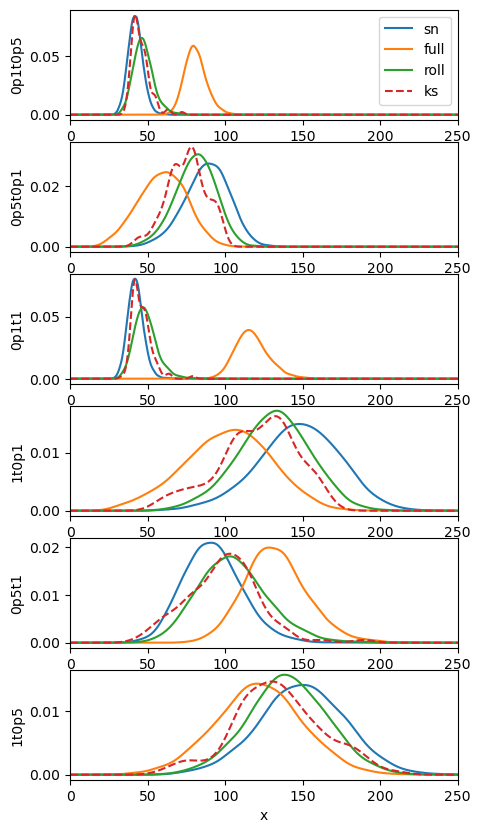

In [148]:
std_vals = sn_toe_non_stat_kde_xr['std'].values

fig = plt.figure(figsize=(5, 10))

axes = [fig.add_subplot(len(std_vals), 1, i+1) for i in range(len(std_vals))]

for num, std in enumerate(std_vals):
    ax=axes[num]
    sn_toe_non_stat_kde_xr.sel(std=std).sn.plot(ax=ax, label='sn')
    sn_toe_non_stat_kde_xr.sel(std=std).sn_lowess_full.plot(ax=ax, label='full')
    sn_toe_non_stat_kde_xr.sel(std=std).sn_roll.plot(ax=ax, label='roll')
    ks_toe_non_stat_kde_xr.sel(std=std).plot(ax=ax, label='ks', linestyle='--')
    # fga_toe_non_stat_kde_xr.sel(std=std).plot(ax=ax, label='ao', linestyle='--')
    
    ax.set_xlim(0, 250)
    ax.set_ylabel(std)
    ax.set_title(None)
    if num == 0: ax.legend()

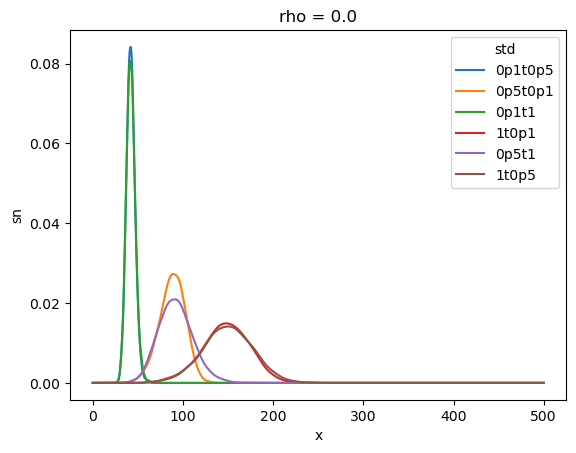

In [149]:
sn_toe_non_stat_kde_xr.sn.plot(hue='std');

(0.0, 200.0)

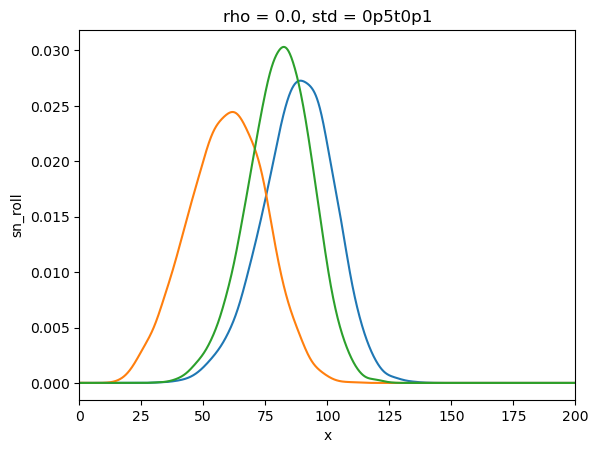

In [150]:
sn_toe_non_stat_kde_xr.isel(std=1).sn.plot()
sn_toe_non_stat_kde_xr.isel(std=1).sn_lowess_full.plot()
sn_toe_non_stat_kde_xr.isel(std=1).sn_roll.plot()

plt.xlim(0, 200)

(0.0, 200.0)

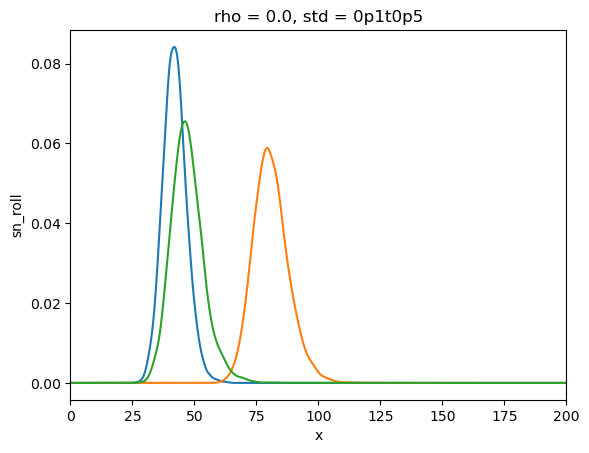

In [151]:
sn_toe_non_stat_kde_xr.isel(std=0).sn.plot()
sn_toe_non_stat_kde_xr.isel(std=0).sn_lowess_full.plot()
sn_toe_non_stat_kde_xr.isel(std=0).sn_roll.plot()
plt.xlim(0, 200)

<h2 style='color:yellow'> Plots </h2>

In [152]:
def __format_multi_axes(axes):

    for i, ax in enumerate(axes):
        if i in [0, 3]:
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
            ax.set_xlabel("Time of Emergence (ToE)", fontsize=14)
        elif i in [2, 5]:
            ax.set_xlabel("Time of Emergence (ToE)", fontsize=14)

        if i in [1, 4]:
            ax.set_xticklabels([])
        else:
            ax.tick_params(axis='x', labelsize=12)

In [183]:
def plot_toe_bs_kde_custom(
    kde_xr, toe_xr,
    colors=None, fig=None, gs=None, axs=None, add_legend=True, legend_loc='upper right',
    fontscale=1, bbox_to_anchor=None, xlim=None, hspace=0.1):
    """
    Plots Time of Emergence (ToE) KDE distributions for different datasets (KS and FGA) as variables within a merged dataset,
    with distinct colors for each dataset and different std values with distinct linestyles.

    Parameters:
    - kde_xr: xarray.Dataset containing KDE distributions with 'KS' and 'FGA' as variables
    - std_values: List of std values to plot
    - colors: Optional color list for datasets
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    x = kde_xr.x.values  # Assuming all datasets share the same x values
    std_values = kde_xr['std'].values
    toe_metrics = list(kde_xr)
    
    nrows = int(np.ceil(len(std_values)/2))
    # Create figure and gridspec if not provided
    if fig is None: fig = plt.figure(figsize=(15, 3.33*nrows))
    if gs is None: gs = gridspec.GridSpec(nrows, 2, figure=fig, hspace=hspace)

    if axs is None:
        axs = []
        for j in range(2):  # Since you have 2 columns
            for i in range(nrows):
                axs.append(fig.add_subplot(gs[i, j]))

    # ylims = []
    for i, std in enumerate(std_values):
        ax = axs[i]
        xlim_array = []
        # ylims.append(kde_xr.sel(std=std).to_array().max().values.item())
        for toe_met in toe_metrics:
            style = toe_plots.TEST_STYLES.get(toe_met, {'color':'black', 'linestyle':'sold'})
            data = kde_xr[toe_met].sel(std=std)
            label= toe_plots.METRIC_MAP.get(toe_met, toe_met).replace('\n', ' ').replace(' (', '\n(')
            if 'Smirnov' in label: label = label.replace('Smirnov', '\nSmirnov')
            ax.plot(x, data, label=label, linewidth=1.9*fontscale, alpha=0.75, **style)
            # median_x = np.nanmedian(toe_xr[toe_met].sel(std=std).values)
            # median_y = data.values[np.argmin(np.abs(x - median_x))]
            # ax.plot([median_x, median_x], [0, median_y], **style)


            max_non_zero =  x[np.where(data.values > 0)[-1][-1]]
            xlim_array.append(max_non_zero)
        
        if xlim: ax.set_xlim(0, xlim)
        else: ax.set_xlim(0,np.max(xlim_array))
        # xlims = (0, 100) if i%2 else (0, 120)
        # ax.set_xlim(xlims)
        # ax.set_xlim(0, 200)
        ax.grid(True, linestyle="--", alpha=0.25, color="grey")
        # ax.annotate(r'$\sigma=$' + std.replace('p', '.').replace('t', ' to '), fontsize=12*fontscale,
        #            xy=(0.02, 0.85), xycoords='axes fraction')

        # ax.set_ylabel(r'$\sigma=$' + std.replace('p', '.').replace('t', ' to '), fontsize=12*fontscale)
        ax.tick_params(axis='x', labelsize=10*fontscale)
        ax.tick_params(axis='y', labelsize=10*fontscale)
        # ax.set_ylim(-0.01, 1.2* kde_xr.sel(std=std_order).to_array().max().values.item())#0.17)

    [ax.set_ylim(-0.001, 1.2 * ax.get_ylim()[1]) for ax in axs]
    # for i in range(nrows):
    #     ylim = np.max([ylims[i], ylims[i+nrows]])
    #     axs[i].set_ylim(-0.01, ylim); axs[i+nrows].set_ylim(-0.01, ylim)
    
    if add_legend:
        legend = axs[0].legend(ncol=1, loc=legend_loc, fontsize=9*fontscale, bbox_to_anchor=bbox_to_anchor)

    return fig, axs

In [154]:
non_stat_tests = list(toe_non_stat_kde_xr)
non_stat_tests

['sn', 'sn_lowess_full', 'sn_roll', 'ks', 'frac']

In [155]:
std_order = list(toe_non_stat_kde_xr['std'].values)
std_order = np.array([*std_order[::2], *std_order[1::2]])
std_order

array(['0p1t0p5', '0p1t1', '0p5t1', '0p5t0p1', '1t0p1', '1t0p5'],
      dtype='<U7')

In [156]:
# std_order = list(toe_non_stat_kde_xr['std'].values)
# ['0p1t0p5', '0p5t1p0', '0p1t1p0', '0p5t0p1', '1p0t0p5', '1p0t0p1',
             # '1p5t0p5','0p5t1p5','3p0t1p0','1p0t3p0'
            # ]

In [157]:
# good_indices = [3,4,5, 8, 9, 10, 13, 14]

In [158]:
# increasing_std = std_order[:len(std_order)//2]
# decreasing_std = std_order[len(std_order)//2:]

In [159]:
# good_std = np.asarray([*decreasing_std[good_indices], *increasing_std[good_indices]])
# small_subset = ['0p1t1p0', '0p1t1p5','0p25t1p5',
#                 '1p0t0p1', '1p5t0p1','1p5t0p25']

In [160]:
sn_toe_bs_xr.sel(rho=0).median(dim='iteration').to_pandas()

std
0.10     41.0
0.25     59.0
0.50     88.0
0.75    119.0
1.00    151.0
dtype: float64

In [161]:
toe_non_stat_xr.sn.median(dim='iteration')

<xarray.DataArray 'sn' (std: 6)> Size: 48B
42.0 89.0 42.0 148.0 91.0 150.0
Coordinates:
  * std      (std) <U7 168B '0p1t0p5' '0p5t0p1' '0p1t1' '1t0p1' '0p5t1' '1t0p5'
    rho      float64 8B 0.0

Text(0.5, 1.0, 'Increasing Variability over Time')

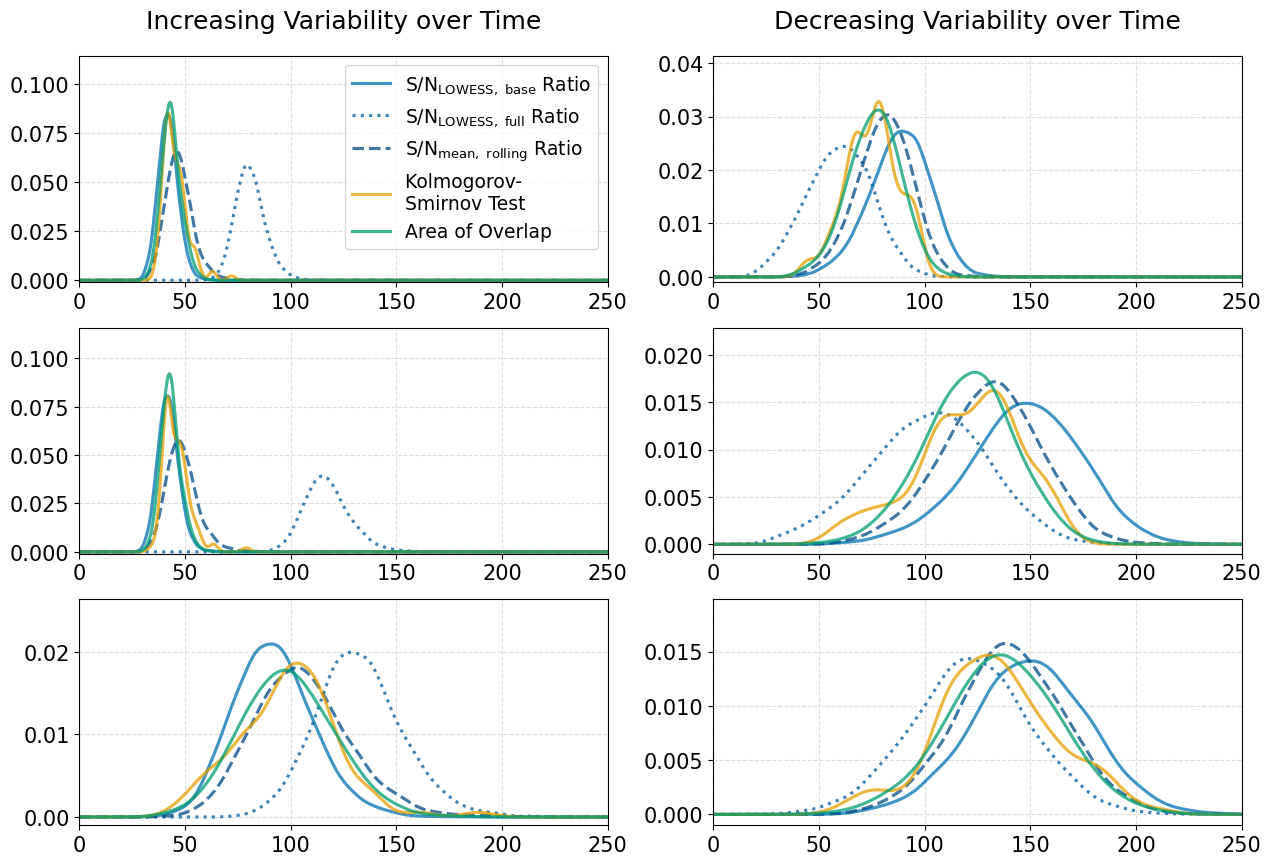

In [162]:
fontscale = 1.5

fig, axs = plot_toe_bs_kde_custom(toe_non_stat_kde_xr.sel(std=std_order).round(5), toe_non_stat_xr,
                                 fontscale=fontscale, xlim=250, hspace=0.2)#, bbox_to_anchor=(2.15, 1.3))

axs[len(axs)//2].set_title('Decreasing Variability over Time', fontsize=12*fontscale, pad=20)
axs[0].set_title('Increasing Variability over Time', fontsize=12*fontscale, pad=20)
# __format_multi_axes(axs)

In [163]:
std_dict = {}
for val in std_order:
    prefix = val.split('t')[0]
    std_dict.setdefault(prefix, []).append(val)

In [164]:
std_dict

{'0p1': ['0p1t0p5', '0p1t1'],
 '0p5': ['0p5t1', '0p5t0p1'],
 '1': ['1t0p1', '1t0p5']}

In [165]:
std_items = std_dict['0p5']

In [166]:
std_items

['0p5t1', '0p5t0p1']

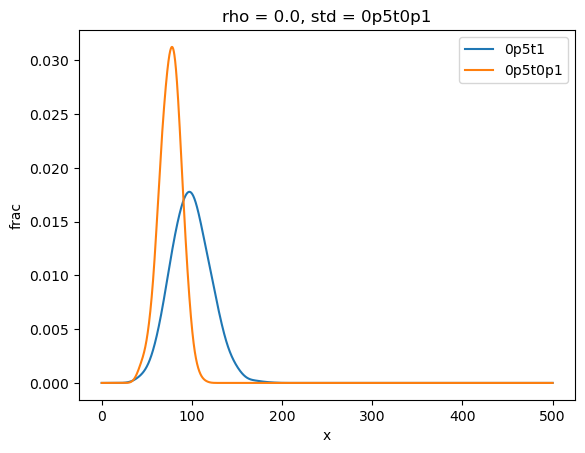

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111)

for std in std_items:
    toe_non_stat_kde_xr.sel(std=std).frac.plot(ax=ax, label=std)

ax.legend()

<h1 style='color:cyan'> Combing Mean and Variances Changes </h1>

In [168]:
# linewidths = np.linspace(3, 0.2, 5+1)
# alphas = np.linspace(0.4, 1, 4)

In [169]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

In [170]:
def plot_toe_bs_kde_v2(toe_bs_kde_xr, toe_bs_xr, colors=None, fig=None, ax=None,
                    add_legend=True, ylabel=True, color_list='k', linestyle='solid',
                      xlabel=True):
    """
    Plots Time of Emergence (ToE) bootstrapped KDE distributions for different std values, with vertical median lines.
    
    Parameters:
    - toe_bs_kde_xr: xarray.Dataset containing KDE distributions for ToE
    - toe_bs_xr: xarray.Dataset containing raw ToE values for computing medians
    - x: numpy array of x-axis values
    - fig: Optional matplotlib figure
    - axs: Optional list of matplotlib axes
    
    Returns:
    - fig, axs: Matplotlib figure and axes
    """
    # Get unique values for rho and std
    rho_values = toe_bs_kde_xr['rho'].values
    std_values = toe_bs_kde_xr['std'].values
    x = toe_bs_kde_xr.x.values
    
    
    # Create figure and gridspec if not provided
    if fig is None or axs is None:
        fig = plt.figure(figsize=(6, len(std_values) * 1.5))
        ax = fig.add_subplot(111)

    linewidths = np.linspace(3, 0.2, len(rho_values)+1)
    alphas = np.linspace(0.4, 1, len(rho_values))
    # Loop through std (rows)
    for i, std in enumerate(std_values):
        # Plot all rho values on the same subplot, using consistent colors
        if isinstance(color_list, str): color=color_list
        else: color=color_list[i]
        for j, rho in enumerate(rho_values):
            data = toe_bs_kde_xr.sel(std=std, rho=rho)
            ax.plot(x, data, color=color, linewidth=linewidths[j],
                    alpha=alphas[j], label=f'{rho:.2f}')
            
            # Compute and plot the median vertical line
            median_x = np.nanmedian(toe_bs_xr.sel(std=std, rho=rho).values)
            median_y = data.values[np.argmin(np.abs(x - median_x))]
            ax.plot(
                [median_x, median_x], [0, median_y],
                linestyle="dashed", linewidth=linewidths[j], color=color, alpha=alphas[j])

        
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5, min_n_ticks=4, prune=None))
        ax.set_xlim(0, 300)
        if xlabel: ax.set_xlabel('Time of Emergence (ToE)', fontsize=12)    
        ax.grid(True, linestyle='--', alpha=0.25, color='grey')


    if add_legend:
        # Create legend entries
        std_line_list = [mlines.Line2D([], [], color=color, label=std)
                         for color, std in zip(color_list, std_subset)]
        
        rho_line_list = [mlines.Line2D([], [], color='grey', linewidth=lw, label=rho, alpha=alpha)
                         for lw, alpha, rho in zip(linewidths, alphas, rho_values)]
        
        # First legend: Standard Deviation
        leg1 = axes[0].legend(
            ncol=3, handles=std_line_list, title='Standard Deviation',
            loc='upper center', fontsize=10, title_fontsize=10, bbox_to_anchor=(0.2, 1.65))
        # Add the first legend manually so the second one doesn't overwrite it
        axes[0].add_artist(leg1)
        # Second legend: Lag-1 Autocorrelation
        axes[0].legend(
            ncol=4, handles=rho_line_list, title='Lag-1 Autocorrelation',
            loc='upper center', fontsize=10, title_fontsize=10, bbox_to_anchor=(0.7, 1.65))
    
    return fig, axs

In [179]:
# color_list = ['#1f77b4', '#ff7f0e', '#8bc34a']
# color_list = ['#0072B2', '#E69F00', '#009E73']  # Blue, Orange, Green
color_list = ['#009E73','#0072B2', '#E69F00', ]  # Green, Blue, Orange 
# color_list = ['#1b9e77', '#d95f02', '#7570b3']  # Teal, Rust, Purple

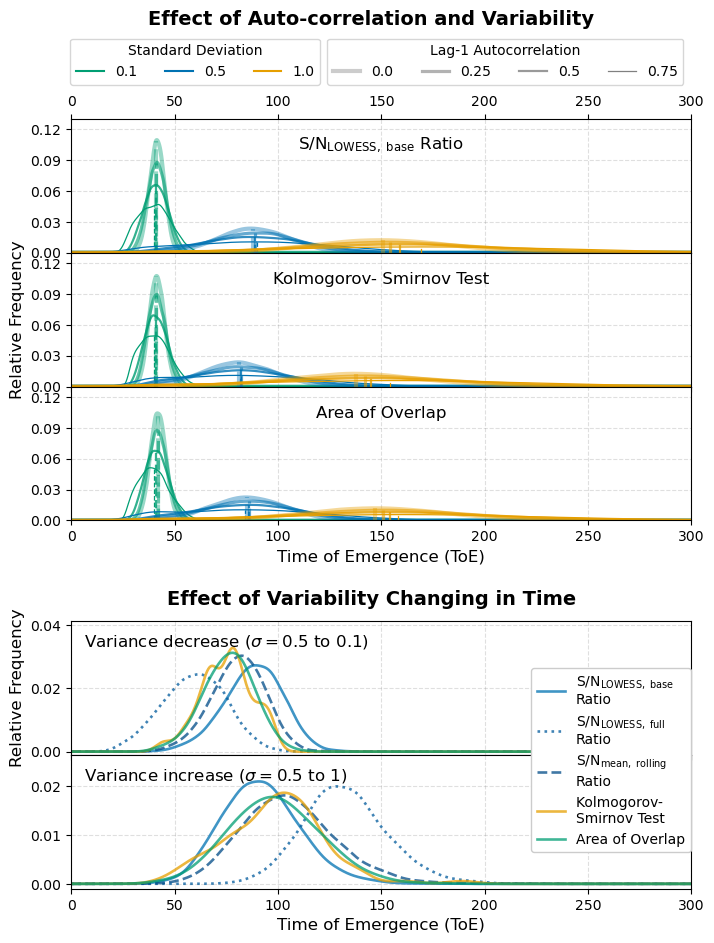

In [184]:
# fig = plt.figure(figsize=(8, 14))
fig = plt.figure(figsize=(8, 10))


subplot_height = .333
outer_gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.3, height_ratios=[3*subplot_height, 2*subplot_height])

gs_top = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0], hspace=0)
axes =[fig.add_subplot(gs_top[i]) for i in range(3)]

gs_bottom = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer_gs[1], hspace=0.)
axes_bottom =[fig.add_subplot(gs_bottom[i]) for i in range(2)]
fig.text(0.5, 0.97, "Effect of Auto-correlation and Variability",
         ha='center', va='bottom', fontsize=14, weight='bold')
fig.text(0.5, 0.39, "Effect of Variability Changing in Time",
         ha='center', va='bottom', fontsize=14, weight='bold')

#######
std_subset = [0.1 , 0.5 , 1.  ]

plot_toe_bs_kde_v2(
    sn_toe_bs_kde_xr.sel(std=std_subset), sn_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[0], color_list=color_list, add_legend=False);

plot_toe_bs_kde_v2(
    ks_toe_bs_kde_xr.sel(std=std_subset), ks_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[1], color_list=color_list, add_legend=False, xlabel=False);

plot_toe_bs_kde_v2(
    fga_toe_bs_kde_xr.sel(std=std_subset), fga_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[2], color_list=color_list, add_legend=True);

axes[1].set_xticklabels([])
# Move ticks and label to top
axes[0].xaxis.tick_top()
# axes[0].xaxis.set_label_position('top')
axes[1].set_ylabel('Relative Frequency', fontsize=12)

ANNOTATE_KWARGS = dict(
    xy=(0.5, 0.8), xycoords='axes fraction', ha='center', va='center',
    color='k', fontsize=12)

axes[0].annotate(METRIC_MAP['sn'], **ANNOTATE_KWARGS)
axes[1].annotate(METRIC_MAP['ks'].replace('\n', ' '), **ANNOTATE_KWARGS)
axes[2].annotate(METRIC_MAP['frac'].replace('\n', ' '), **ANNOTATE_KWARGS)

#### Variance changes

# variance_changes = ['1p0t0p1', '0p5t1p0']
# variance_changes = ['0p25t1p5', '1p5t0p25']
variance_changes = ['0p5t0p1', '0p5t1']
# variance_changes = ['1t0p5', '0p5t1']
# variance_changes = ['0p1t1', '1t0p1']


fig, axes_bottom = plot_toe_bs_kde_custom(
    toe_non_stat_kde_xr.sel(std = variance_changes), toe_non_stat_xr,
    fig=fig, axs=axes_bottom,add_legend=False, fontscale=1)

# Even though the function has a legend, it's placed behine right column plot
# legend = axes_bottom[0].legend(ncol=2, loc='upper right', fontsize=9)
legend = axes_bottom[-1].legend(ncol=1, loc='upper right', fontsize=10,
                               bbox_to_anchor=(1.01, 1.7))


# Update legend labels with line break before 'Ratio'
for text in legend.get_texts():
    new_text = text.get_text().replace('Ratio', '\nRatio')
    text.set_text(new_text)

legend.get_frame().set_alpha(1.0)         # Fully opaque

for ax in axes_bottom:
    ax.set_xlabel('Time of Emergence (ToE)', fontsize=12)
    ax.set_xlim(0, 300)
    # ax.set_ylim(0, 0.044)# 1.2*ax.get_ylim()[-1]) #-0.001

for ax in axes:#[*axes, *axes_bottom]:
    ax.set_ylim(0, 0.13)# 1.2*ax.get_ylim()[-1]) #-0.001


std = variance_changes[0]
axes_bottom[0].annotate(
    'Variance decrease ' + r'($\sigma=$' + std.replace('p', '.').replace('t', ' to ') +')',
    fontsize=12, xy=(0.02, 0.81), xycoords='axes fraction')


std = variance_changes[-1]
axes_bottom[-1].annotate(
    'Variance increase ' + r'($\sigma=$' + std.replace('p', '.').replace('t', ' to ') +')',
    fontsize=12, xy=(0.02, 0.81), xycoords='axes fraction')


axes_bottom[0].set_ylabel('Relative Frequency', fontsize=12)

axes_bottom[0].set_xticklabels([]);

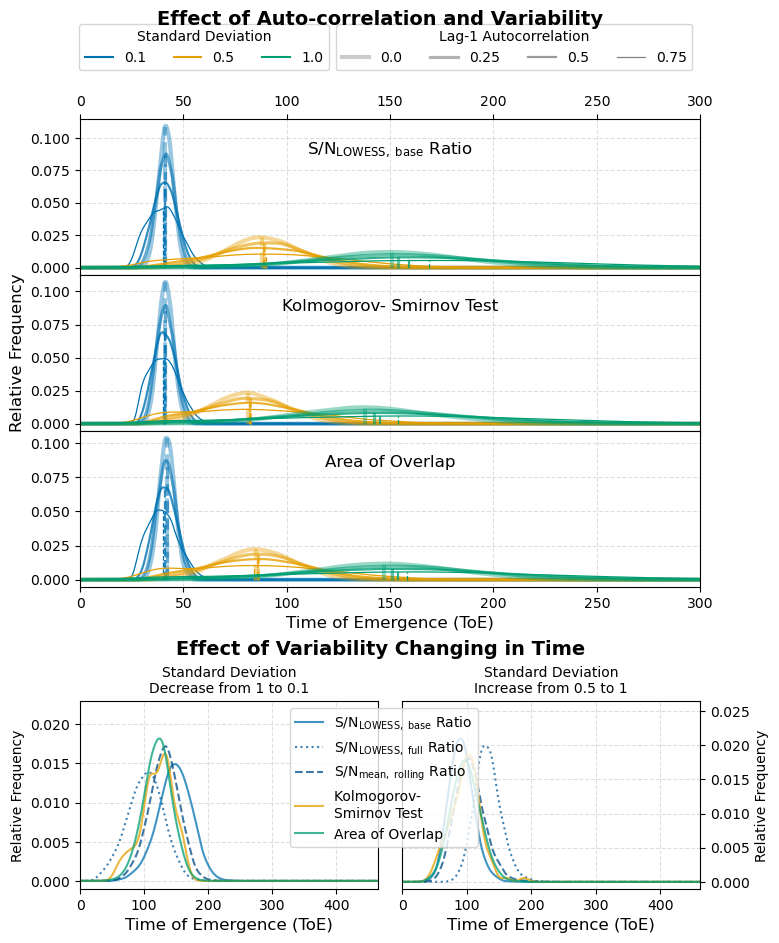

In [175]:
# fig = plt.figure(figsize=(8, 14))
fig = plt.figure(figsize=(8, 10))

outer_gs = gridspec.GridSpec(2, 1, figure=fig, hspace=0.35, height_ratios=[1, 0.4])

gs_top = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer_gs[0], hspace=0)
axes =[fig.add_subplot(gs_top[i]) for i in range(3)]

gs_bottom = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_gs[1], wspace=0.08)
axes_bottom =[fig.add_subplot(gs_bottom[i]) for i in range(2)]
fig.text(0.5, 0.97, "Effect of Auto-correlation and Variability",
         ha='center', va='bottom', fontsize=14, weight='bold')
fig.text(0.5, 0.34, "Effect of Variability Changing in Time",
         ha='center', va='bottom', fontsize=14, weight='bold')

#######
std_subset = [0.1 , 0.5 , 1.  ]

plot_toe_bs_kde_v2(
    sn_toe_bs_kde_xr.sel(std=std_subset), sn_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[0], color_list=color_list, add_legend=False);

plot_toe_bs_kde_v2(
    ks_toe_bs_kde_xr.sel(std=std_subset), ks_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[1], color_list=color_list, add_legend=False, xlabel=False);

plot_toe_bs_kde_v2(
    fga_toe_bs_kde_xr.sel(std=std_subset), fga_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[2], color_list=color_list, add_legend=True);

axes[1].set_xticklabels([])
# Move ticks and label to top
axes[0].xaxis.tick_top()
# axes[0].xaxis.set_label_position('top')
axes[1].set_ylabel('Relative Frequency', fontsize=12)

ANNOTATE_KWARGS = dict(
    xy=(0.5, 0.8), xycoords='axes fraction', ha='center', va='center',
    color='k', fontsize=12)

axes[0].annotate(METRIC_MAP['sn'], **ANNOTATE_KWARGS)
axes[1].annotate(METRIC_MAP['ks'].replace('\n', ' '), **ANNOTATE_KWARGS)
axes[2].annotate(METRIC_MAP['frac'].replace('\n', ' '), **ANNOTATE_KWARGS)

#### Variance changes


variance_changes = ['1t0p1', '0p5t1']
# variance_changes = ['1p5t0p5', '0p5t1p5']


fig, axes_bottom= plot_toe_bs_kde_custom(
    toe_non_stat_kde_xr.sel(std = variance_changes), toe_non_stat_xr,
    fig=fig, axs=axes_bottom,add_legend=False)

# Even though the function has a legend, it's placed behine right column plot
legend = axes_bottom[-1].legend(loc='upper left', fontsize=10,
                       bbox_to_anchor=(-.4, 1))

for ax in axes_bottom:
    ax.set_ylabel('Relative Frequency')
    ax.set_xlabel('Time of Emergence (ToE)', fontsize=12)   

axes_bottom[0].set_title(
    'Standard Deviation\nDecrease from ' +\
     variance_changes[0].replace('p', '.').replace('t', ' to '),
    fontsize=10)
axes_bottom[1].set_title(
    'Standard Deviation\nIncrease from ' +\
    variance_changes[1].replace('p', '.').replace('t', ' to '),
    fontsize=10)

axes_bottom[-1].yaxis.tick_right()                     # Move y-axis ticks to the right
axes_bottom[-1].yaxis.set_label_position("right")     # Move y-axis label to the right
axes_bottom[-1].tick_params(labelright=True, labelleft=False)  # Show labels on right, hide on left

Text(0.5, 0.8, 'Area of Overlap')

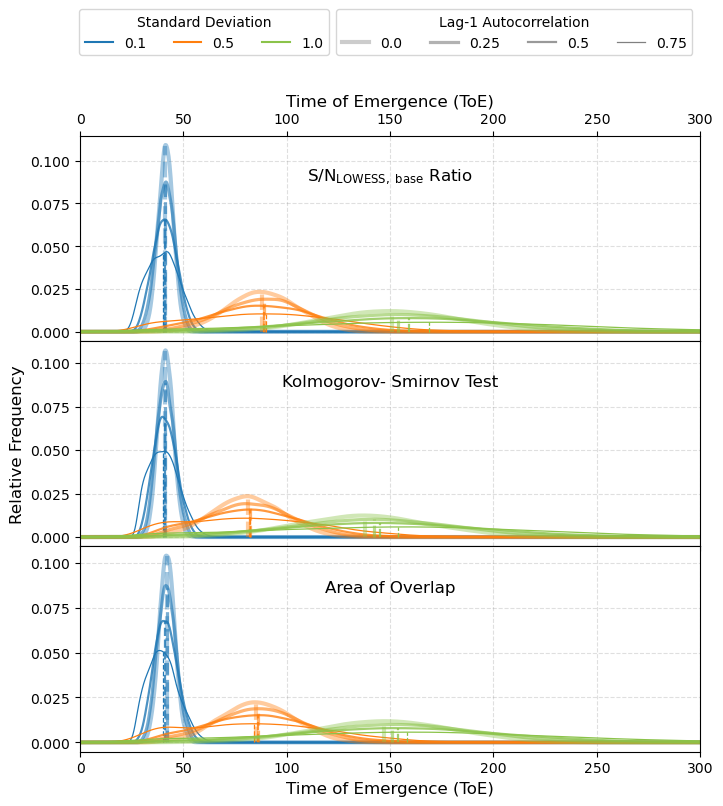

In [1131]:

fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(3, 1, figure=fig, hspace=0)
axes =[fig.add_subplot(gs[i]) for i in range(3)]


color_list = ['#1f77b4', '#ff7f0e', '#8bc34a']
std_subset = [0.1 , 0.5 , 1.  ]

plot_toe_bs_kde_v2(
    sn_toe_bs_kde_xr.sel(std=std_subset), sn_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[0], color_list=color_list, add_legend=False);

plot_toe_bs_kde_v2(
    ks_toe_bs_kde_xr.sel(std=std_subset), ks_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[1], color_list=color_list, add_legend=False, xlabel=False);

plot_toe_bs_kde_v2(
    fga_toe_bs_kde_xr.sel(std=std_subset), fga_toe_bs_xr.sel(std=std_subset),
    fig=fig, ax=axes[2], color_list=color_list, add_legend=True);

axes[1].set_xticklabels([])
# Move ticks and label to top
axes[0].xaxis.tick_top()
axes[0].xaxis.set_label_position('top')
axes[1].set_ylabel('Relative Frequency', fontsize=12)

ANNOTATE_KWARGS = dict(
    xy=(0.5, 0.8), xycoords='axes fraction', ha='center', va='center',
    color='k', fontsize=12)

axes[0].annotate(METRIC_MAP['sn'], **ANNOTATE_KWARGS)
axes[1].annotate(METRIC_MAP['ks'].replace('\n', ' '), **ANNOTATE_KWARGS)
axes[2].annotate(METRIC_MAP['frac'].replace('\n', ' '), **ANNOTATE_KWARGS)

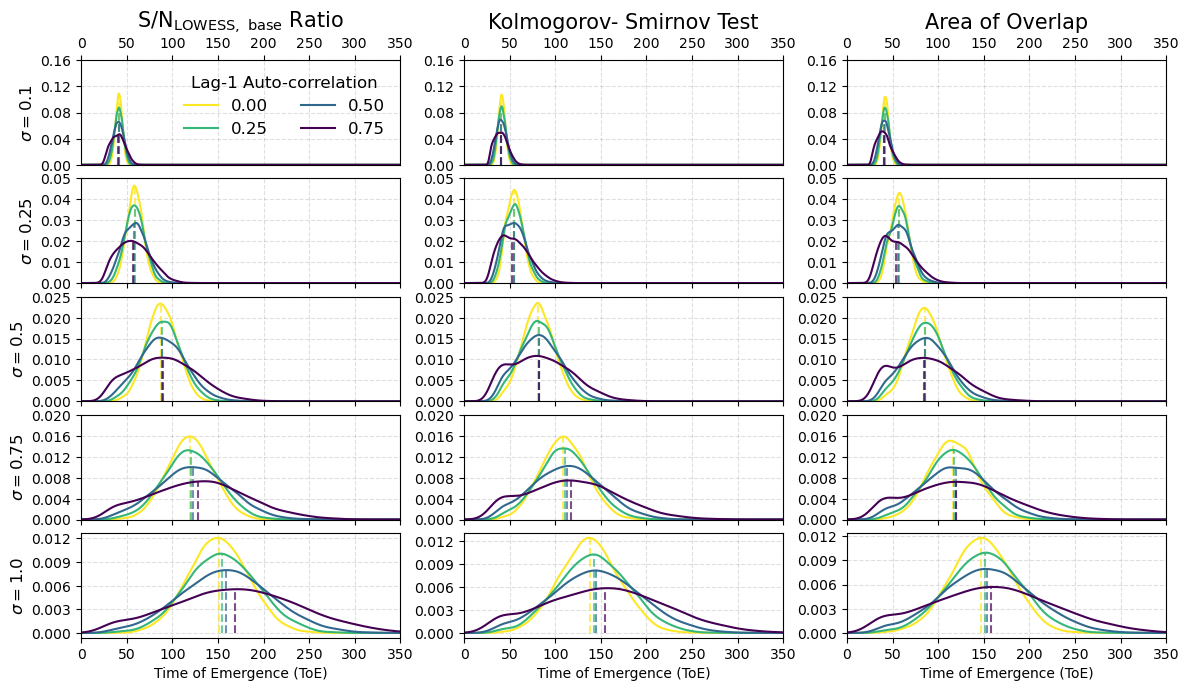

In [1132]:
# Create figure and gridspec (multiple rows, 1 column)
fig = plt.figure(figsize=(14, len(std_values) * 1.5))
gs = gridspec.GridSpec(len(ks_toe_bs_kde_xr['std'].values), 3, figure=fig, hspace=0.13)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_middle = [fig.add_subplot(gs[i, 1]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]
axes_right = [fig.add_subplot(gs[i, 2]) for i in range(len(ks_toe_bs_kde_xr['std'].values))]


plot_toe_bs_kde(sn_toe_bs_kde_xr, sn_toe_bs_xr, fig=fig, axs=axes_left, colors=colors);
plot_toe_bs_kde(ks_toe_bs_kde_xr, ks_toe_bs_xr, fig=fig, axs=axes_middle, colors=colors, ylabel=False, add_legend=False);
plot_toe_bs_kde(fga_toe_bs_kde_xr, fga_toe_bs_xr, fig=fig, axs=axes_right, colors=colors, ylabel=False, add_legend=False);


axes_left[0].set_title(METRIC_MAP['sn'], fontsize=15)
axes_middle[0].set_title(METRIC_MAP['ks'].replace('\n', ' '), fontsize=15)
axes_right[0].set_title(METRIC_MAP['frac'].replace('\n', ' '), fontsize=15)


for axes in [axes_left, axes_middle, axes_right]:
    for i,ax in enumerate(axes):
        if i == 0: ax.set_ylim(0, 0.16)
        if i == 1:ax.set_ylim(0, 0.05)
        if i == 2: ax.set_ylim(0, 0.025)
        if i==3: ax.set_ylim(0, 0.02)

<h1 style='color:yellow'> Trend Demonstartion </h1>

In [1138]:
colors = plt.cm.viridis_r(np.linspace(0, 1, trend_bs_xr['rho'].values.shape[0]))

In [1139]:
trend_bs_xr_sample = trend_bs_xr.isel(iteration=0).compute()

In [1140]:
trend_non_stat_xr_sample = trend_noise_change_xr.isel(iteration=0).compute()

In [1146]:
trend_noise_change_xr

<xarray.DataArray 'data' (std: 6, iteration: 10000, time: 400)> Size: 192MB
dask.array<chunksize=(1, 1000, 400), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
    rho        float64 8B 0.0
  * std        (std) <U7 168B '0p1t0p5' '0p5t0p1' '0p1t1' ... '0p5t1' '1t0p5'
  * time       (time) int64 3kB 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399

In [1141]:
non_stat_std_values = trend_noise_change_xr['std'].values

In [1142]:
grad_label = grad * 10
# grad_label2 = grad_label/2

In [1145]:
length_dict

{'0p1t0p5': 146,
 '0p5t0p1': 146,
 '0p1t1': 272,
 '1t0p1': 272,
 '0p5t1': 272,
 '1t0p5': 272}

In [1159]:
non_stat_std_values

array(['0p1t0p5', '0p5t0p1', '0p1t1', '1t0p1', '0p5t1', '1t0p5'],
      dtype='<U7')

In [1175]:
length_dict

{'0p1t0p5': 146,
 '0p5t0p1': 146,
 '0p1t1': 272,
 '1t0p1': 272,
 '0p5t1': 272,
 '1t0p5': 272}

Text(0.5, 0.3, 'Variability Changing in Time')

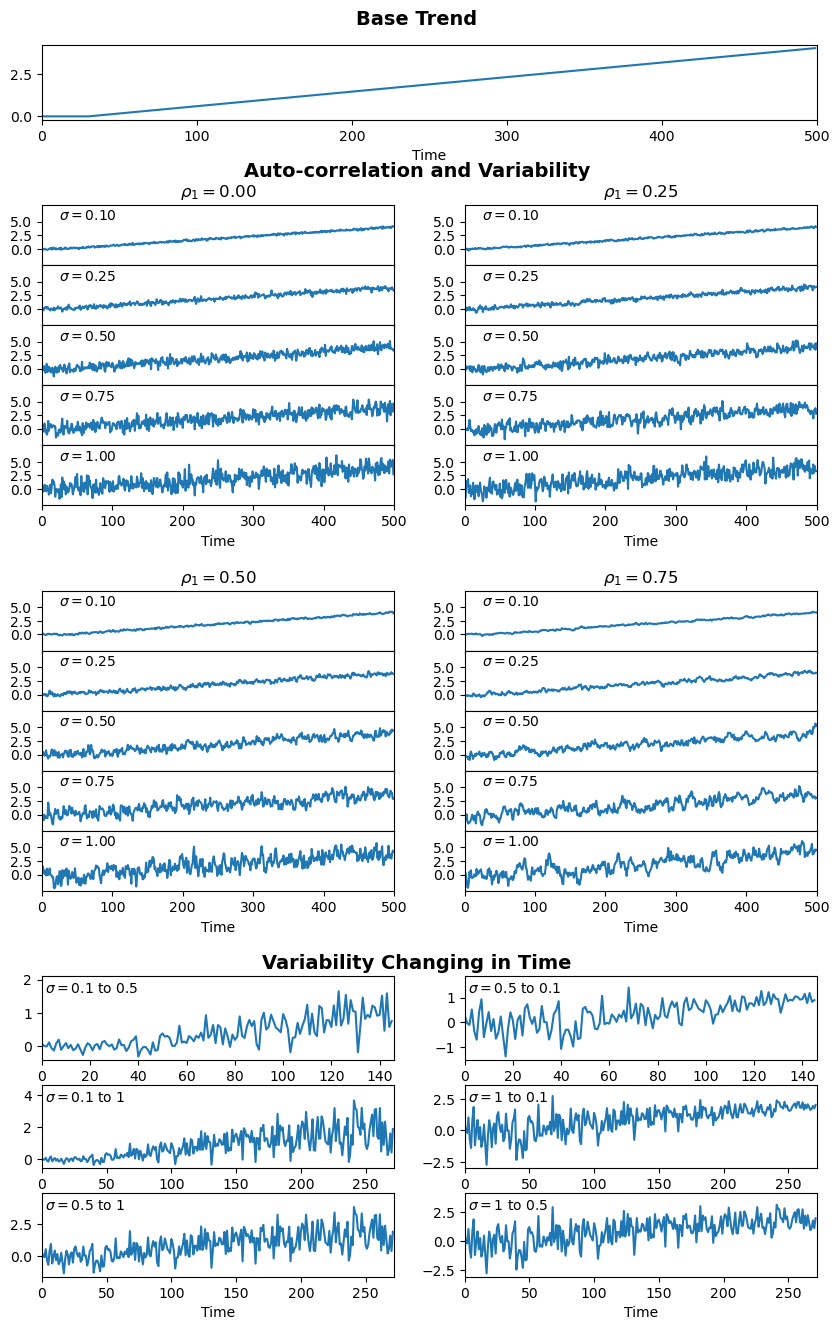

In [1205]:
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4,2, hspace=0.35, height_ratios=[0.25, 1, 1, 1])
ax_top = fig.add_subplot(gs[0, :])

ax_top.plot(true_trend, label=f'{grad_label:.2f} per decade')
# ax_top.plot(true_trend/2, label=f'{grad_label2:.2f} per decade')
ax_top.set_xlim(0, 500)
# ax_top.legend()
ax_top.set_xlabel('Time')

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    rho_gs = gridspec.GridSpecFromSubplotSpec(len(std_values), 1, hspace=0, subplot_spec=gs[2+num])
    rho_axes = [fig.add_subplot(rho_gs[i]) for i in range(len(std_values))]
    for num2, std in enumerate(std_values):
        ax = rho_axes[num2]
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values)
        ax.annotate(r'$\sigma=$'+f'{std:0.2f}', xy=(0.05, 0.75), xycoords='axes fraction')

        # ax.set_ylabel(r'$\sigma=$'+f'\n{std:0.2f}', rotation=0, labelpad=15)
        ax.set_yticks([0, 2.5, 5])
        ax.set_ylim(-3, 8)
        ax.set_xlim(0, 500)
        if num2 < (len(std_values)-1):
            ax.set_xticklabels([])
    
    rho_axes[-1].set_xlabel('Time')
    
    rho_axes[0].set_title(r'$\rho_1=$'+f'{rho:0.2f}')


# non_stat_ax1 = fig.add_subplot(gs[-2])
# non_stat_ax2 = fig.add_subplot(gs[-1])

non_stat_std_values = std_order#trend_non_stat_xr_sample['std'].values

left_gs = gridspec.GridSpecFromSubplotSpec(
    len(non_stat_std_values)//2, 1, 
    hspace=0.3, subplot_spec=gs[-1, 0])
right_gs = gridspec.GridSpecFromSubplotSpec(
    len(non_stat_std_values)//2, 1,
    hspace=0.3, subplot_spec=gs[-1, 1])

axes_left = [fig.add_subplot(left_gs[i]) for i in range(len(non_stat_std_values)//2)]
axes_right = [fig.add_subplot(right_gs[i]) for i in range(len(non_stat_std_values)//2)]


for i in range(3):
    std_vali  = non_stat_std_values[i]
    std_valim  = non_stat_std_values[i+len(non_stat_std_values)//2]
    

    trend_non_stat_xr_sample.sel(std=std_vali).isel(time=slice(0, length_dict[std_vali])).plot(
        ax=axes_left[i], #alpha=0.5,
        # label=std_vali.replace('p', '.').replace('t', ' to ')
    )
    
    trend_non_stat_xr_sample.sel(std=std_valim).isel(time=slice(0, length_dict[std_valim])).plot(
        ax=axes_right[i], #lpha=0.5,
        # label=std_valim.replace('p', '.').replace('t', ' to ')
    )

    axes_left[i].annotate(r'$\sigma=$'+std_vali.replace('p', '.').replace('t', ' to '),
                          xy=(0.01, 0.8), xycoords='axes fraction')
    axes_right[i].annotate(r'$\sigma=$'+std_valim.replace('p', '.').replace('t', ' to '),
                           xy=(0.01, 0.8),xycoords='axes fraction')

    axes_left[i].set_ylim(axes_left[i].get_ylim()[0], 1.2*axes_left[i].get_ylim()[-1])
    axes_right[i].set_ylim(axes_right[i].get_ylim()[0], 1.2*axes_right[i].get_ylim()[-1])


    axes_left[i].set_xlim(0, length_dict[std_vali])
    axes_right[i].set_xlim(0, length_dict[std_valim])

axes_left[i].set_xlabel('Time')
axes_right[i].set_xlabel('Time')


for num3, ax in enumerate([*axes_left, *axes_right]):
    ax.set_title(None)
    ax.set_ylabel(None)


# for i in [0, 1]:
#     axes_left[i].set_xticklabels([])
#     axes_right[i].set_xticklabels([])

leg1 = non_stat_ax1.legend()
leg1.set_title('Variance Change')

leg2 = non_stat_ax2.legend()
leg2.set_title('Variance Change')
non_stat_ax1.set_title('Increasing Variance', fontsize=14)
non_stat_ax2.set_title('Decreasing Variance', fontsize=14)


fig.text(0.5, 0.89, "Base Trend",
         ha='center', va='bottom', fontsize=14, weight='bold')

fig.text(0.5, 0.795, "Auto-correlation and Variability",
         ha='center', va='bottom', fontsize=14, weight='bold')
fig.text(0.5, 0.3, "Variability Changing in Time",
         ha='center', va='bottom', fontsize=14, weight='bold')

Text(0.5, 0.23, 'Effect of Variability Changing in Time')

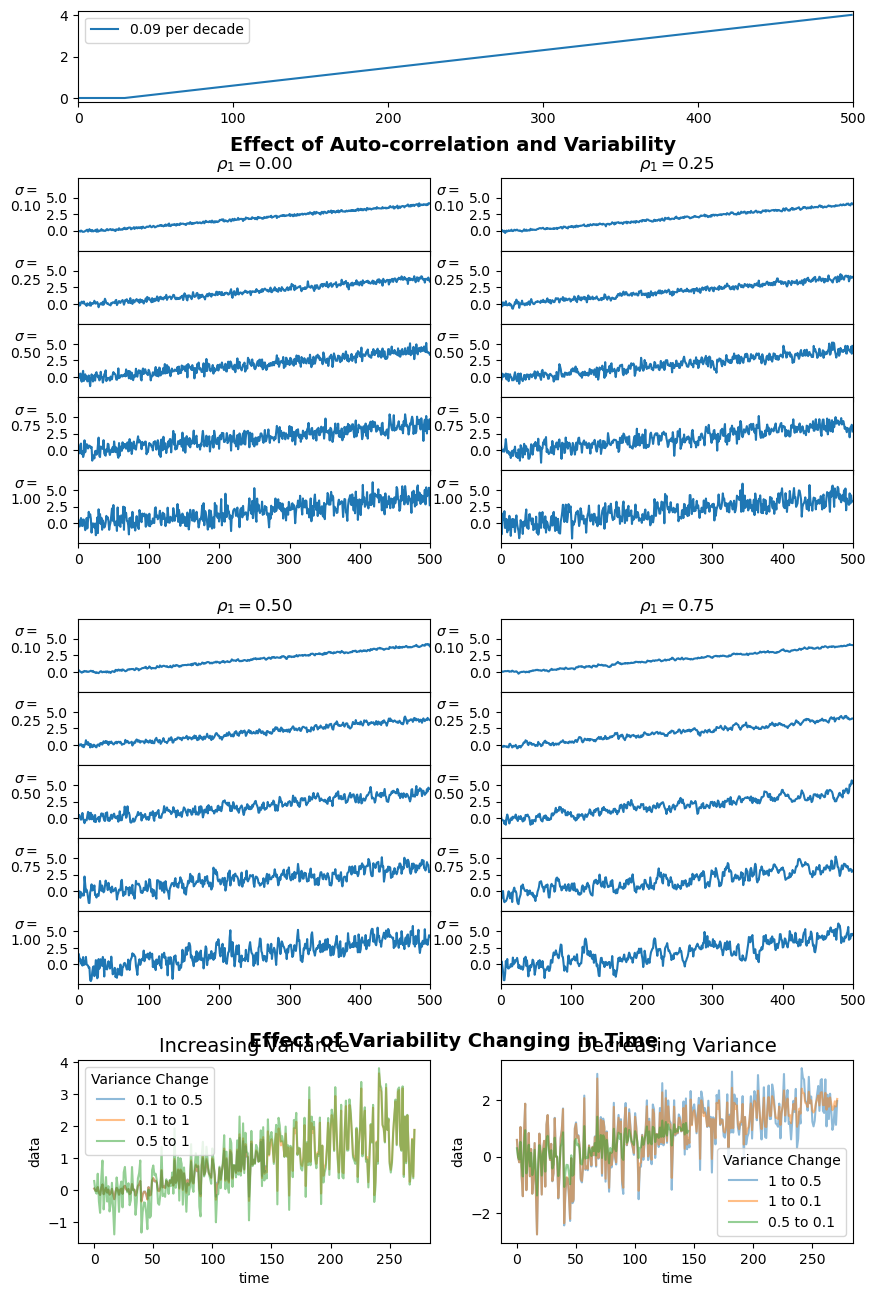

In [1190]:
fig = plt.figure(figsize=(10, 16))
gs = gridspec.GridSpec(4,2, hspace=0.3, height_ratios=[0.25, 1, 1, 0.5])
ax_top = fig.add_subplot(gs[0, :])

ax_top.plot(true_trend, label=f'{grad_label:.2f} per decade')
# ax_top.plot(true_trend/2, label=f'{grad_label2:.2f} per decade')
ax_top.set_xlim(0, 500)
ax_top.legend()

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    rho_gs = gridspec.GridSpecFromSubplotSpec(len(std_values), 1, hspace=0, subplot_spec=gs[2+num])
    rho_axes = [fig.add_subplot(rho_gs[i]) for i in range(len(std_values))]
    for num2, std in enumerate(std_values):
        ax = rho_axes[num2]
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values)
        ax.set_ylabel(r'$\sigma=$'+f'\n{std:0.2f}', rotation=0, labelpad=15)
        ax.set_yticks([0, 2.5, 5])
        ax.set_ylim(-3, 8)
        ax.set_xlim(0, 500)
        if num2 < (len(std_values)-1):
            ax.set_xticklabels([])
        
    rho_axes[0].set_title(r'$\rho_1=$'+f'{rho:0.2f}')


non_stat_ax1 = fig.add_subplot(gs[-2])
non_stat_ax2 = fig.add_subplot(gs[-1])


non_stat_std_values = std_order#trend_non_stat_xr_sample['std'].values
for i in range(3):
    std_vali  = non_stat_std_values[i]
    std_valim  = non_stat_std_values[-i-1]
    

    trend_non_stat_xr_sample.sel(std=std_vali).isel(time=slice(0, length_dict[std_vali])).plot(
        ax=non_stat_ax1, alpha=0.5,
        label=std_vali.replace('p', '.').replace('t', ' to ')
    )
    
    trend_non_stat_xr_sample.sel(std=std_valim).isel(time=slice(0, length_dict[std_valim])).plot(
        ax=non_stat_ax2, alpha=0.5,
        label=std_valim.replace('p', '.').replace('t', ' to ')
    )

leg1 = non_stat_ax1.legend()
leg1.set_title('Variance Change')

leg2 = non_stat_ax2.legend()
leg2.set_title('Variance Change')
non_stat_ax1.set_title('Increasing Variance', fontsize=14)
non_stat_ax2.set_title('Decreasing Variance', fontsize=14)



In [ ]:
fig = plt.figure(figsize=(6, 10))
gs = gridspec.GridSpec(5,2)

ax_top = fig.add_subplot(gs[0, :])
rho_axes = np.array([fig.add_subplot(gs[row, col]) for row, col in [(1, 0), (1,1), (2, 0), (2, 1)]]).ravel()

ax_top.plot(true_trend)
ax_top.plot(true_trend/2)

std_values = trend_bs_xr_sample['std'].values
rho_values = trend_bs_xr_sample['rho'].values

for num,rho in enumerate(rho_values):
    ax = rho_axes[num]
    for std in std_values:
        ax.plot(trend_bs_xr_sample.sel(rho=rho, std=std).values, alpha=0.5)

In [ ]:
trend_non_stat_xr

In [ ]:
trend_bs_xr

<h1 style='color:cyan'> Non-stationary Variance Old </h1> - Old

<h2 style='color:yellow'> Generating Data </h2>

In [101]:
attempt_no = 2

In [102]:
reload(toe_calc_variations)

<module 'toe_calc_variations' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py'>

In [103]:
true_trend.shape

(500,)

In [104]:
base_noise_xr = generate_noise_ensemble(
            1, 0, length=true_trend.shape[0],
            rtol=0.2, num_trials=10000)


std=1 - rho=0 - length=500 - atol=0.2

1 (0), 2 (100), 3 (200), 4 (300), 5 (400), 6 (500), 7 (600), 8 (700), 9 (800), 10 (900), 11 (1000), 12 (1100), 13 (1200), 14 (1300), 15 (1400), 16 (1500), 17 (1600), 18 (1700), 19 (1800), 20 (1900), 21 (2000), 22 (2100), 23 (2200), 24 (2300), 25 (2400), 26 (2500), 27 (2600), 28 (2700), 29 (2800), 30 (2900), 31 (3000), 32 (3100), 33 (3200), 34 (3300), 35 (3400), 36 (3500), 37 (3600), 38 (3700), 39 (3800), 40 (3900), 41 (4000), 42 (4100), 43 (4200), 44 (4300), 45 (4400), 46 (4500), 47 (4600), 48 (4700), 49 (4800), 50 (4900), 51 (5000), 52 (5100), 53 (5200), 54 (5300), 55 (5400), 56 (5500), 57 (5600), 58 (5700), 59 (5800), 60 (5900), 61 (6000), 62 (6100), 63 (6200), 64 (6300), 65 (6400), 66 (6500), 67 (6600), 68 (6700), 69 (6800), 70 (6900), 71 (7000), 72 (7100), 73 (7200), 74 (7300), 75 (7400), 76 (7500), 77 (7600), 78 (7700), 79 (7800), 80 (7900), 81 (8000), 82 (8100), 83 (8200), 84 (8300), 85 (8400), 86 (8500), 87 (8600), 88 (8700), 89 (8800), 90

In [105]:
non_stationary_noise

<function __main__.non_stationary_noise(arr: numpy.ndarray, start_std: float, end_std: float, window: int) -> numpy.ndarray>

In [106]:
non_stat_noise_kwargs = dict(
    input_core_dims=[['time']],
    output_core_dims = [['time']],
    vectorize=True,
    dask = 'parallelized',
    output_dtypes=[float]
)

In [107]:
base_noise_0p1t1p0_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.1, end_std=1, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p1t1p0_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [108]:
base_noise_0p1t0p5_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.1, end_std=0.5, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p1t0p5_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [109]:
base_noise_0p5t1p0_xr = xr.apply_ufunc(
    non_stationary_noise, 
    base_noise_xr,
    kwargs = dict(start_std=0.5, end_std=1, window=30),
    **non_stat_noise_kwargs
).persist()
wait(base_noise_0p5t1p0_xr);

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 38.15 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [110]:
def revers_time_values(ds):
    ds2 = ds.copy(deep=True)
    ds2.data = ds2.data[..., ::-1]
    return ds2

In [111]:
# Reverse nosie for trends with decreasing noise
base_noise_1p0t0p1_xr = revers_time_values(base_noise_0p1t1p0_xr)
base_noise_1p0t0p5_xr = revers_time_values(base_noise_0p5t1p0_xr)
base_noise_0p5t0p1_xr = revers_time_values(base_noise_0p1t0p5_xr)

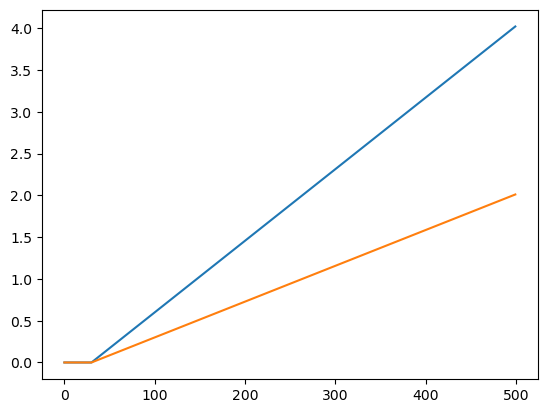

In [112]:
plt.plot(true_trend)
plt.plot(true_trend/2)

In [113]:
# Increading trends
# Divide true trend by 2 as ToE is too early
trend_0p1t1p0_xr = base_noise_0p1t1p0_xr + true_trend#/2
trend_0p5t1p0_xr = base_noise_0p5t1p0_xr + true_trend#/2
trend_0p1t0p5_xr = base_noise_0p1t0p5_xr + true_trend#/2

In [114]:
# Decrsing trends
trend_1p0t0p1_xr = base_noise_1p0t0p1_xr + true_trend
trend_1p0t0p5_xr = base_noise_1p0t0p5_xr + true_trend
trend_0p5t0p1_xr = base_noise_0p5t0p1_xr + true_trend

In [115]:
trend_0p1t1p0_xr['std'] = '0p1t1p0'
trend_0p5t1p0_xr['std'] = '0p5t1p0'
trend_0p1t0p5_xr['std'] = '0p1t0p5'
trend_1p0t0p1_xr['std'] = '1p0t0p1'
trend_1p0t0p5_xr['std'] = '1p0t0p5'
trend_0p5t0p1_xr['std'] = '0p5t0p1'

In [116]:
trend_non_stat_xr = xr.concat(
    [trend_0p1t1p0_xr, trend_0p5t1p0_xr, trend_0p1t0p5_xr,
     trend_1p0t0p1_xr, trend_1p0t0p5_xr, trend_0p5t0p1_xr], dim='std')

In [117]:
trend_non_stat_xr

<xarray.DataArray (std: 6, iteration: 10000, time: 500)> Size: 240MB
dask.array<chunksize=(1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    rho        int64 8B 0
  * std        (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'

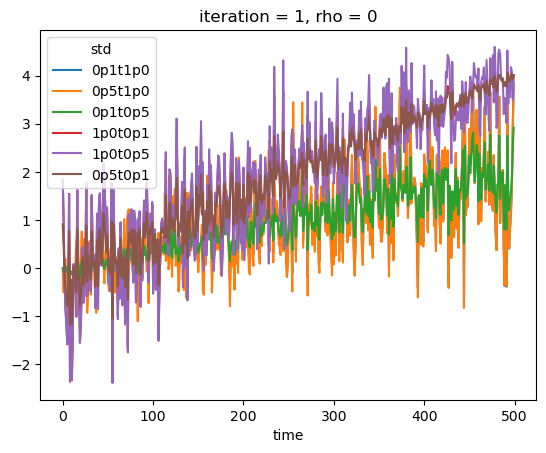

In [118]:
trend_non_stat_xr.isel(iteration=1).plot(hue='std');

<h2 style='color:yellow'> ToE Calculation </h2>

In [119]:
data_ds_window_non_stat = (trend_non_stat_xr
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds_non_stat = (trend_non_stat_xr.sel(time=slice(0, base_period_length))
                         # .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )
wait(data_ds_window_non_stat);
wait(base_period_window_ds_non_stat);

In [120]:
%%time
ks_non_stat_ds = toe_calc_variations.ks(data_ds_window_non_stat.isel(iteration=slice(0,100)),
                                        base_period_window_ds_non_stat.isel(iteration=slice(0,100)))

In [121]:
trend_non_stat_xr

<xarray.DataArray (std: 6, iteration: 10000, time: 500)> Size: 240MB
dask.array<chunksize=(1, 10000, 500), meta=np.ndarray>
Coordinates:
  * iteration  (iteration) int64 80kB 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * time       (time) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
    rho        int64 8B 0
  * std        (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'

In [122]:

fga_non_stat_ds = toe_calc_variations.fga(
    trend_non_stat_xr,#.isel(iteration=slice(0,100)),
    trend_non_stat_xr.isel(time=slice(0, base_period_length)),#.isel(iteration=slice(0,100)),
    data_ds_window_non_stat#.isel(iteration=slice(0,100))
).compute()

In [123]:
reload(toe_calc_variations)

<module 'toe_calc_variations' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_calc_variations.py'>

In [124]:
%%time
sn_non_stat_xr = toe_calc_variations.sn_ratio(
    trend_non_stat_xr,#.isel(iteration=slice(0,100)),
    start=0, end=30)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 228.90 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [145]:
sn_non_stat_xr

<xarray.Dataset> Size: 1GB
Dimensions:         (iteration: 10000, time: 500, std: 6)
Coordinates:
  * iteration       (iteration) int64 80kB 0 1 2 3 4 ... 9996 9997 9998 9999
  * time            (time) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
    rho             int64 8B 0
  * std             (std) <U7 168B '0p1t1p0' '0p5t1p0' ... '1p0t0p5' '0p5t0p1'
Data variables:
    sn              (std, iteration, time) float64 240MB 0.3106 0.292 ... 7.731
    sn_lowess_full  (std, iteration, time) float64 240MB 0.06535 ... 12.1
    sn_roll         (std, iteration, time) float64 240MB nan nan nan ... nan nan
    noise           (std, iteration, time) float64 240MB -0.04482 ... 0.01647
    signal          (std, iteration, time) float64 240MB 0.0389 ... 3.846

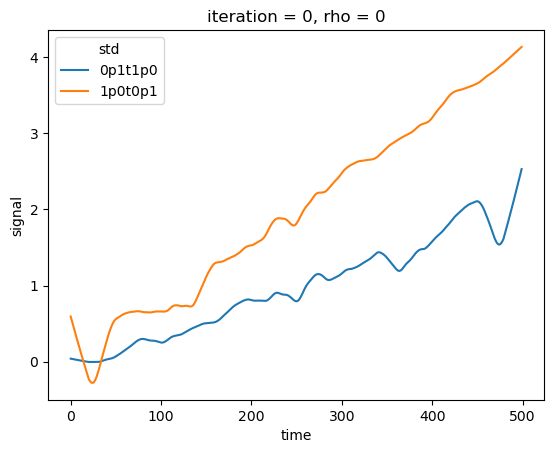

In [125]:
sn_non_stat_xr.signal.sel(std=['0p1t1p0', '1p0t0p1']).isel(iteration=0).plot(hue='std');

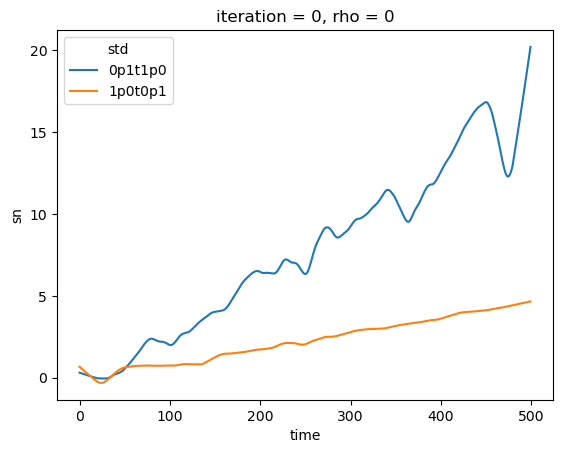

In [126]:
sn_non_stat_xr.sn.sel(std=['0p1t1p0', '1p0t0p1']).isel(iteration=0).plot(hue='std');

<h2 style='color:yellow'>  Saving and Opening Data </h2>

In [35]:
# base_noise_xr.to_zarr(os.path.join(SAVE_DIR, 'base_noise_non_stat_var.zarr'), mode='w')
# trend_non_stat_xr.to_zarr(os.path.join(SAVE_DIR, 'trend_non_stat_var.zarr'), mode='w')
# sn_non_stat_xr.to_zarr(os.path.join(SAVE_DIR, 'sn_non_stat_var.zarr'), mode='w')
# ks_non_stat_ds.to_zarr(os.path.join(SAVE_DIR, 'ks_non_stat_var.zarr'), mode='w')
# fga_non_stat_ds.to_zarr(os.path.join(SAVE_DIR, 'ga_non_stat_var.zarr'), mode='w')

In [36]:
chunks = {'time':-1, 'iteration':200}

In [37]:
base_noise_xr = xr.open_zarr(os.path.join(SAVE_DIR, 'base_noise_non_stat_var.zarr')).to_array().chunk(**chunks)
trend_non_stat_xr = xr.open_zarr(os.path.join(SAVE_DIR, 'trend_non_stat_var.zarr')).chunk(**chunks)
sn_non_stat_xr = xr.open_zarr(os.path.join(SAVE_DIR, 'sn_non_stat_var.zarr')).chunk(**chunks)
ks_non_stat_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'ks_non_stat_var.zarr')).chunk(**chunks)
fga_non_stat_ds = xr.open_zarr(os.path.join(SAVE_DIR, 'ga_non_stat_var.zarr')).chunk(**chunks)

<h2 style='color:yellow'>  ToE Calculation </h2>

In [39]:
%%time
sn_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
    sn_non_stat_xr[['sn', 'sn_lowess_full', 'sn_roll']],
    threshold=1, comparison_func=np.greater,
    time=sn_non_stat_xr.time.values.astype(int), trim_nan=True).compute()

CPU times: user 9.66 s, sys: 3.91 s, total: 13.6 s
Wall time: 17.2 s


In [38]:
%%time
ks_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            ks_non_stat_ds, threshold=0.01, comparison_func=np.less, time=ks_non_stat_ds.time.values).compute()

CPU times: user 1.64 s, sys: 753 ms, total: 2.39 s
Wall time: 3.67 s


In [40]:
fga_toe_non_stat_xr = toe_calc.get_permanent_exceedance(
            fga_non_stat_ds, threshold=62, comparison_func=np.less, time=fga_non_stat_ds.time.values).compute()

In [42]:
%%time
sn_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    sn_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 5.34 s, sys: 806 ms, total: 6.15 s
Wall time: 3.76 s


In [41]:
%%time
ks_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    ks_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

CPU times: user 95.4 ms, sys: 9.38 ms, total: 105 ms
Wall time: 63.5 ms


<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


In [43]:
%%time
fga_toe_non_stat_kde_xr = xr.apply_ufunc(
    toe_calc.create_kde_x_exists,
    fga_toe_non_stat_xr,
    **kde_create_kwargs
).compute();

<timed exec>:1: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


CPU times: user 1.75 s, sys: 262 ms, total: 2.02 s
Wall time: 1.23 s


In [44]:
ks_toe_non_stat_kde_xr['x'] = x
fga_toe_non_stat_kde_xr['x'] = x
sn_toe_non_stat_kde_xr['x'] = x

# Old 

In [ ]:
for rho in sn_toe_bs_kde_xr['rho'].values:
    plt.plot(x, sn_toe_bs_kde_xr.sel(std=0.1, rho=rho))

In [ ]:
for std in sn_toe_bs_kde_xr['std'].values:
    plt.plot(x, sn_toe_bs_kde_xr.sel(std=std, rho=0.75))

In [ ]:
sn_toe_bs_kde_xr

In [ ]:
sn_toe_bs_xr

In [ ]:

sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)

In [ ]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1

In [ ]:
# toe_median_1#.isel(multiplier=0)

In [ ]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [ ]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [ ]:
ratio_s_std_to_noise_std

In [ ]:
x = np.linspace(0, 200, 1000)

In [ ]:
sn_toe_bs_xr

In [ ]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

In [ ]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [ ]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, 30)).mean(dim='time')

In [ ]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [ ]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, 30)).std(dim='time')

In [ ]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

In [ ]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1

In [ ]:
# toe_median_1#.isel(multiplier=0)

In [ ]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [ ]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [ ]:
ratio_s_std_to_noise_std

In [ ]:
x = np.linspace(0, 200, 1000)

In [ ]:
sn_toe_bs_xr

In [ ]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

In [ ]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [ ]:


noise_bs_xr = generate_noise_ensemble(0.25, 0.2, length=true_trend.shape[0])

In [ ]:
trend_bs_xr = noise_bs_xr + true_trend

In [ ]:
multipliers = [1, 2, 3, 4]

# Stack different noise scalings into a new "multiplier" dimension
trend_bs_xr = xr.concat([true_trend + noise_bs_xr * m for m in multipliers], dim="multiplier")

# Assign correct multiplier labels
trend_bs_xr["multiplier"] = multipliers
trend_bs_xr

In [ ]:
trend_anom_bs_xr = trend_bs_xr - trend_bs_xr.isel(time=slice(0, 30)).mean(dim='time')

In [ ]:
signal_bs_xr = xr.apply_ufunc(
    my_stats.apply_lowess,
    trend_anom_bs_xr,
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True
)

In [ ]:
noise_bs_xr = trend_bs_xr.isel(time=slice(0, 30)).std(dim='time')

In [ ]:
sn_bs_xr = signal_bs_xr/noise_bs_xr

In [ ]:
sn_toe_bs_xr = toe_calc.get_permanent_exceedance(
            sn_bs_xr, threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1 = toe_calc.get_permanent_exceedance(
            sn_bs_xr.median(dim='iteration'), threshold=1, comparison_func=np.greater, time=sn_bs_xr.time.values)

In [ ]:
toe_median_1

In [ ]:
# toe_median_1#.isel(multiplier=0)

In [ ]:
 # Get the std of signal at the time when the median S/N ration between iterations is one
singal_range_list = []
for mult in toe_median_1.multiplier.values:
    median_toe = toe_median_1.sel(multiplier=mult).values.astype(int).item()
    signal_range = signal_bs_xr.sel(multiplier=mult).isel(time=median_toe)#.std()
    singal_range_list.append(signal_range)
signal_range_xr = xr.concat(singal_range_list, dim='multiplier')

In [ ]:
ratio_s_std_to_noise_std = signal_range_xr.std(dim='iteration')/noise_bs_xr.std(dim='iteration')

In [ ]:
ratio_s_std_to_noise_std

In [ ]:
x = np.linspace(0, 200, 1000)

In [ ]:
sn_toe_bs_xr

In [ ]:
sn_toe_bs_kde_m1 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=0).values, x)
sn_toe_bs_kde_m2 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=1).values, x)
sn_toe_bs_kde_m3 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=2).values, x)
sn_toe_bs_kde_m4 = toe_calc.create_kde_x_exists(sn_toe_bs_xr.isel(multiplier=3).values, x)

In [ ]:
plt.plot(x, sn_toe_bs_kde_m1, label='1')
plt.plot(x, sn_toe_bs_kde_m2, label='2')
plt.plot(x, sn_toe_bs_kde_m3, label='3')
plt.plot(x, sn_toe_bs_kde_m4, label='4')
plt.legend()

In [ ]:
noise_bs_xr.plot()

In [ ]:
sn_bs_xr.plot(hue='iteration', add_legend=False);

In [ ]:
signal_bs_xr.plot(hue='iteration', add_legend=False);

In [ ]:
trend_series.plot(hue='iteration', add_legend=False);

In [ ]:
noise_series_xr.plot(hue='iteration', add_legend=False);

In [ ]:
noise_series_list.shape

In [ ]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [ ]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length=base_period.length+1)

In [ ]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).isel(**ensemble_kwargs).values)

In [ ]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2)), **ensemble_kwargs).values, label='roll', alpha=0.5)
plt.legend()